# Проект обучение с учителем: качество модели

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.Необходимо разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Задачи:**
- Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».


- Нужно собрать данные по клиентам по следующим группам:
* 1)Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
* 2)Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
* 3)Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
* 4)Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.


* Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.


* В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.


* Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

**Инструкция по выполнению проекта**
* Разработать модель, которая предскажет вероятность снижения покупательской активности.
* Выделить сегмент покупателей, проанализируйте его и предложите, как увеличить его покупательскую активность. Используйте данные моделирования, данные о прибыли покупателей и исходные данные (если понадобятся). По желанию вы можете проанализировать больше одного сегмента.


## Загрузка данных

In [1]:
!pip install scikit-learn==1.4.2 -q
!pip install imblearn -q
!pip install optuna -q
!pip install shap -q
!pip install phik -q
!pip install mlxtend -q

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from phik.report import plot_correlation_matrix

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    RobustScaler
)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import make_column_transformer
from tqdm import tqdm

from sklearn.utils import shuffle
from sklearn.metrics import (
    recall_score, r2_score, 
    confusion_matrix,
    mean_absolute_error, 
    mean_squared_error, 
    precision_score, 
    accuracy_score,
    roc_auc_score,
    f1_score
)

In [3]:
try:
    market_file = pd.read_csv('/datasets/market_file.csv', sep=',', decimal = '.')
    market_money = pd.read_csv('/datasets/market_money.csv', sep=',', decimal = '.')
    market_time = pd.read_csv('/datasets/market_time.csv', sep=',', decimal = '.')
    money = pd.read_csv('/datasets/money.csv', sep=';', decimal = ',')
except:
    market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv', sep=',', decimal = '.')
    market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv', sep=',', decimal = '.')
    market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv', sep=',', decimal = '.')
    money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';', decimal = ',')

In [4]:
display(market_file.head())
display(market_money.head())
display(market_time.head())
money.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [5]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [6]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [7]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [8]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


**Вывод:** Файлы открыты и изучены,у нас в наличии 4 таблицы, одна основная и 3 с дополнительными данными.Посмотрел на основную информацию о таблицах,можно сразу сказать что пропусков нет и типы данных соответствуют значениям.

##  Предобработка данных


In [9]:
market_file.columns = market_file.columns.str.replace(' ', '_')
market_file.columns = market_file.columns.str.lower()

In [10]:
market_file.duplicated().sum()

0

In [11]:
for column in market_file.columns:
    unique_count = market_file[column].nunique()
    unique_values = market_file[column].unique()
    print(f"Столбец '{column}' имеет {unique_count} unique values:")
    print(unique_values)

Столбец 'id' имеет 1300 unique values:
[215348 215349 215350 ... 216645 216646 216647]
Столбец 'покупательская_активность' имеет 2 unique values:
['Снизилась' 'Прежний уровень']
Столбец 'тип_сервиса' имеет 3 unique values:
['премиум' 'стандартт' 'стандарт']
Столбец 'разрешить_сообщать' имеет 2 unique values:
['да' 'нет']
Столбец 'маркет_актив_6_мес' имеет 41 unique values:
[3.4 4.4 4.9 3.2 5.1 3.3 4.7 4.2 3.9 4.6 4.3 3.8 2.7 4.8 2.9 3.  2.4 1.7
 3.6 4.  1.5 3.5 4.1 3.1 1.4 0.9 5.6 2.6 5.5 5.2 5.8 5.  5.4 5.7 5.3 3.7
 6.3 6.6 4.5 6.1 5.9]
Столбец 'маркет_актив_тек_мес' имеет 3 unique values:
[5 4 3]
Столбец 'длительность' имеет 658 unique values:
[ 121  819  539  896 1064  762  431  284  192  154  450  110  623  199
  438  923  708  167  209  581  829  607  572  365  566  811  268  558
  534  730  488  436  637  554  330  504 1020  721  495  135  663 1047
  152  754  525  169  966  645  706  689  882 1007  304  339  954  771
  699  669  511  974  666  857 1048  756  506  759  768  720  

In [12]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].str.replace('стандартт','стандарт')
market_file['популярная_категория'] = market_file['популярная_категория'].str.replace('Косметика и аксесуары',
                                                                                      'Косметика и акссесуары')
display(market_file['тип_сервиса'].unique())
market_file['популярная_категория'].unique()

array(['премиум', 'стандарт'], dtype=object)

array(['Товары для детей', 'Домашний текстиль', 'Косметика и акссесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

В таблице *market_file* названия столбцов привел в надлежащий вид,  дубликатов нет, изучил уникальные значения каждого столбца, поменял некоторые значения столбцов которые были написаны с ошибкой.

In [13]:
market_money.columns = market_money.columns.str.lower()

In [14]:
for column in market_money.columns:
    unique_count = market_money[column].nunique()
    unique_values = market_money[column].unique()
    print(f"Столбец '{column}' имеет {unique_count} unique values:")
    print(unique_values)

Столбец 'id' имеет 1300 unique values:
[215348 215349 215350 ... 216645 216646 216647]
Столбец 'период' имеет 3 unique values:
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
Столбец 'выручка' имеет 2776 unique values:
[   0.  3293.1 4472.  ... 5224.6 4720.  4448.3]


В таблице *market_money* названия столбцов привел в надлежащий вид, изучил уникальные значения каждого столбца.

In [15]:
market_time.columns = market_time.columns.str.lower()

In [16]:
for column in market_time.columns:
    unique_count = market_time[column].nunique()
    unique_values = market_time[column].unique()
    print(f"Столбец '{column}' имеет {unique_count} unique values:")
    print(unique_values)

Столбец 'id' имеет 1300 unique values:
[215348 215349 215350 ... 216645 216646 216647]
Столбец 'период' имеет 2 unique values:
['текущий_месяц' 'предыдцщий_месяц']
Столбец 'минут' имеет 20 unique values:
[14 13 10 12  8 11  6  7  9  5 15  4 16 17 19 18 22 20 21 23]


In [17]:
market_time['период'] = market_time['период'].str.replace('предыдцщий_месяц','предыдущий_месяц')
market_time['период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

В таблице *market_time* названия столбцов привел в надлежащий вид, изучил уникальные значения каждого столбца, поменял значение 'предыдцщий_месяц' на 'предыдущий_месяц'.

In [18]:
money.columns = money.columns.str.lower()

In [19]:
for column in money.columns:
    unique_count = money[column].nunique()
    unique_values = money[column].unique()
    print(f"Столбец '{column}' имеет {unique_count} unique values:")
    print(unique_values)

Столбец 'id' имеет 1300 unique values:
[215348 215349 215350 ... 216645 216646 216647]
Столбец 'прибыль' имеет 400 unique values:
[0.98 4.16 3.13 4.87 4.21 3.95 3.62 5.26 4.93 4.66 3.06 5.08 4.55 4.03
 3.49 1.83 2.67 3.65 2.95 3.03 6.27 3.86 2.82 1.4  1.63 3.69 4.08 4.18
 4.26 4.27 4.42 3.88 2.42 4.78 4.85 4.05 3.48 5.16 4.6  5.7  5.44 4.1
 2.93 3.9  3.28 5.09 3.19 4.77 5.01 6.73 7.43 4.28 3.73 3.38 3.47 5.
 2.02 3.68 2.68 4.46 2.41 5.4  3.4  4.22 4.5  4.98 3.96 3.18 4.65 3.92
 3.89 5.64 2.76 4.25 3.71 4.63 2.97 3.24 3.81 4.04 6.33 4.68 3.6  3.04
 4.41 3.98 2.47 4.52 4.01 5.31 2.53 5.83 4.48 2.98 4.92 3.08 4.9  3.94
 2.99 4.62 3.76 3.42 4.17 4.47 4.69 4.59 2.84 3.66 4.97 2.19 2.74 5.41
 4.12 3.93 5.02 3.52 3.39 6.12 4.64 3.14 4.71 4.99 3.74 4.   5.23 2.08
 6.55 2.36 4.32 3.15 2.77 5.56 3.44 3.58 2.92 4.67 3.33 2.94 1.06 2.45
 4.86 5.05 3.2  2.8  4.13 1.81 2.79 4.11 2.55 3.84 3.17 4.51 3.45 3.27
 4.2  4.33 3.01 5.79 3.12 6.59 6.88 2.7  2.69 5.49 2.34 5.25 3.25 4.74
 3.77 4.34 5.06 4.95 

В таблице *money* названия столбцов привел в надлежащий вид, изучил уникальные значения каждого столбца.

## Исследовательский анализ данных

### исследовательский анализ данных

In [20]:
market_file.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,1300.0,NaN,NaN,NaN,215997.5,375.421985,215348.0,215672.75,215997.5,216322.25,216647.0
покупательская_активность,1300,2,Прежний уровень,802,NaN,NaN,NaN,NaN,NaN,NaN,NaN
тип_сервиса,1300,2,стандарт,924,NaN,NaN,NaN,NaN,NaN,NaN,NaN
разрешить_сообщать,1300,2,да,962,NaN,NaN,NaN,NaN,NaN,NaN,NaN
маркет_актив_6_мес,1300.0,NaN,NaN,NaN,4.253769,1.014814,0.9,3.7,4.2,4.9,6.6
маркет_актив_тек_мес,1300.0,NaN,NaN,NaN,4.011538,0.696868,3.0,4.0,4.0,4.0,5.0
длительность,1300.0,NaN,NaN,NaN,601.898462,249.856289,110.0,405.5,606.0,806.0,1079.0
акционные_покупки,1300.0,NaN,NaN,NaN,0.319808,0.249843,0.0,0.17,0.24,0.3,0.99
популярная_категория,1300,6,Товары для детей,330,NaN,NaN,NaN,NaN,NaN,NaN,NaN
средний_просмотр_категорий_за_визит,1300.0,NaN,NaN,NaN,3.27,1.35535,1.0,2.0,3.0,4.0,6.0


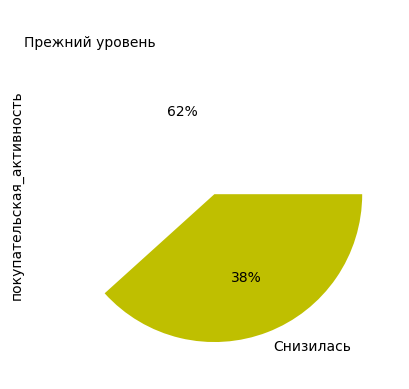

In [21]:
market_file['покупательская_активность'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors={'w', 'y'});

Целевой признак имеет два признака, для баланса применим стратификацию при разделении. 

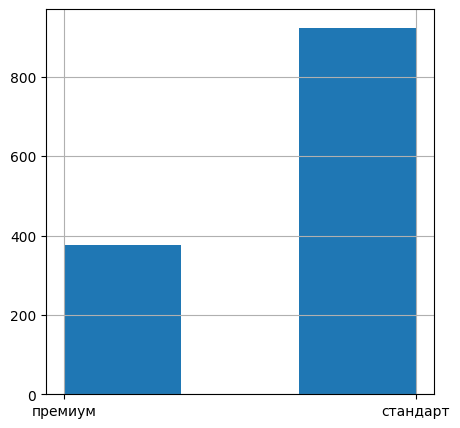

In [22]:
market_file.тип_сервиса.hist(bins = 3, figsize = (5,5));

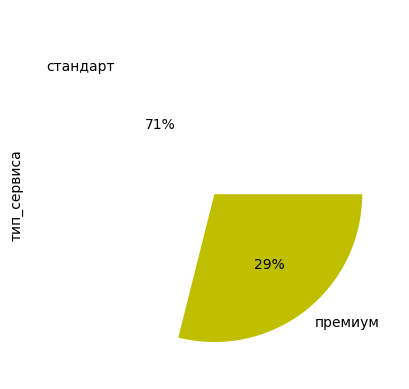

In [23]:
market_file['тип_сервиса'].value_counts().plot( 
    kind='pie', autopct='%1.0f%%', colors={'w', 'y'});

Клиентов с *премимум* подпиской 29%, остальные со стандартной.

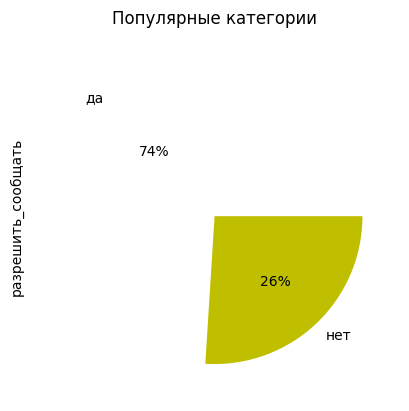

In [24]:
market_file['разрешить_сообщать'].value_counts().plot(
    title='Популярные категории', 
    kind='pie', autopct='%1.0f%%', colors={'w', 'y'});

Более 70% клиентво разрешили получать информацию о дополнительных акциях.

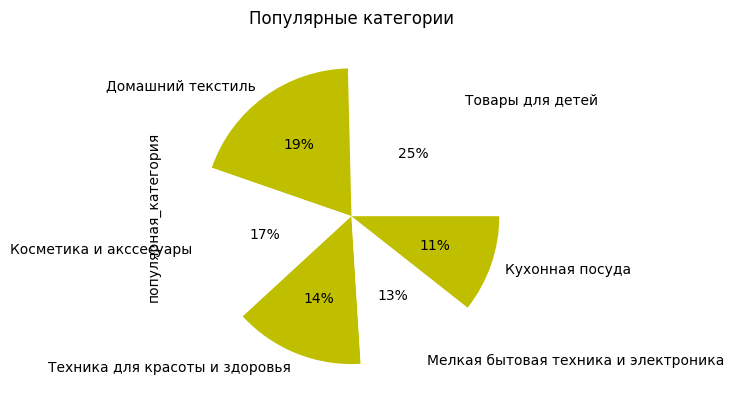

In [25]:
market_file['популярная_категория'].value_counts().plot(
    title='Популярные категории', 
    kind='pie', autopct='%1.0f%%', colors={'w', 'y'});

Самая популярная категория *товары для детей*.Всего 6 категорий товаров.

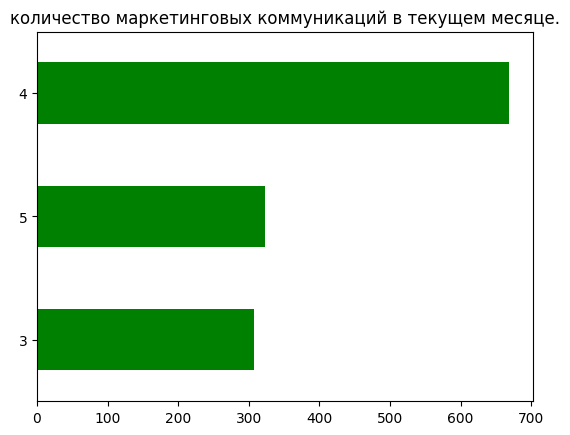

In [26]:
market_file['маркет_актив_тек_мес'].value_counts(ascending=True).plot.barh(
    title='количество маркетинговых коммуникаций в текущем месяце.',
    color='g'
);

Количество маркетинговых коммуникаций в текущем месяце от 3 до 5,больше всего значений рассылок приходится на 4.

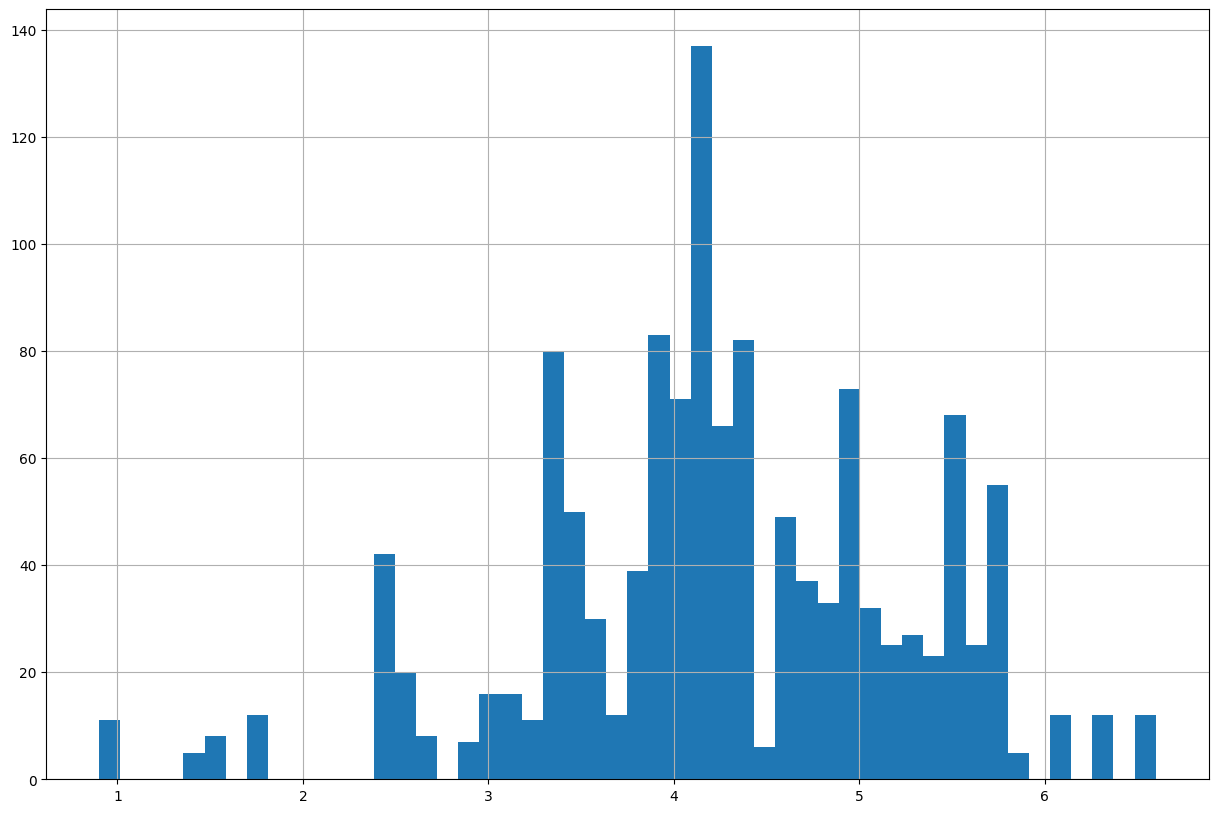

In [27]:
market_file.маркет_актив_6_мес.hist(bins = 50, figsize = (15,10));

Среднемесячное значение маркетинговых коммуникаций компании,больше всего рассылок в среднем 4 шт

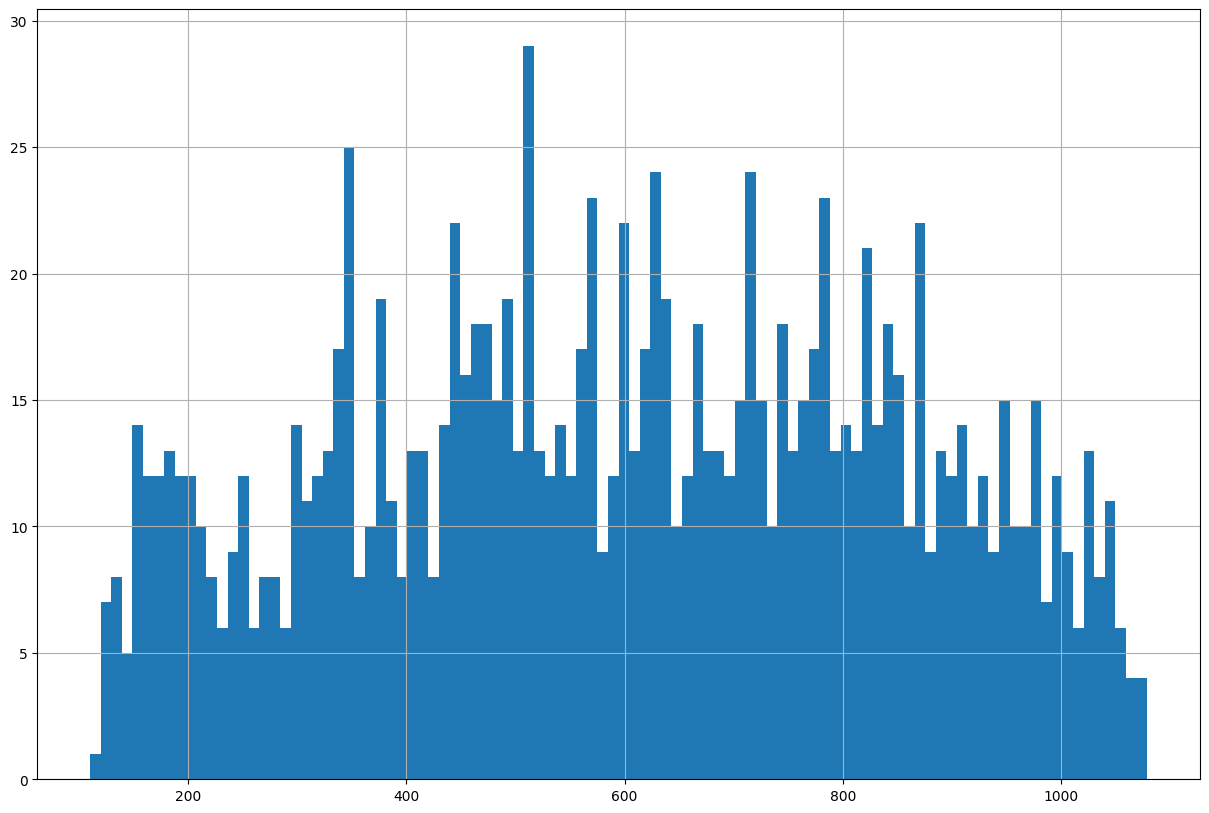

In [28]:
market_file.длительность.hist(bins = 100, figsize = (15,10));

Длительность показывает сколько дней прошло с момента регистрации покупателя на сайте,значения от 3 месяцев до 3,5 лет

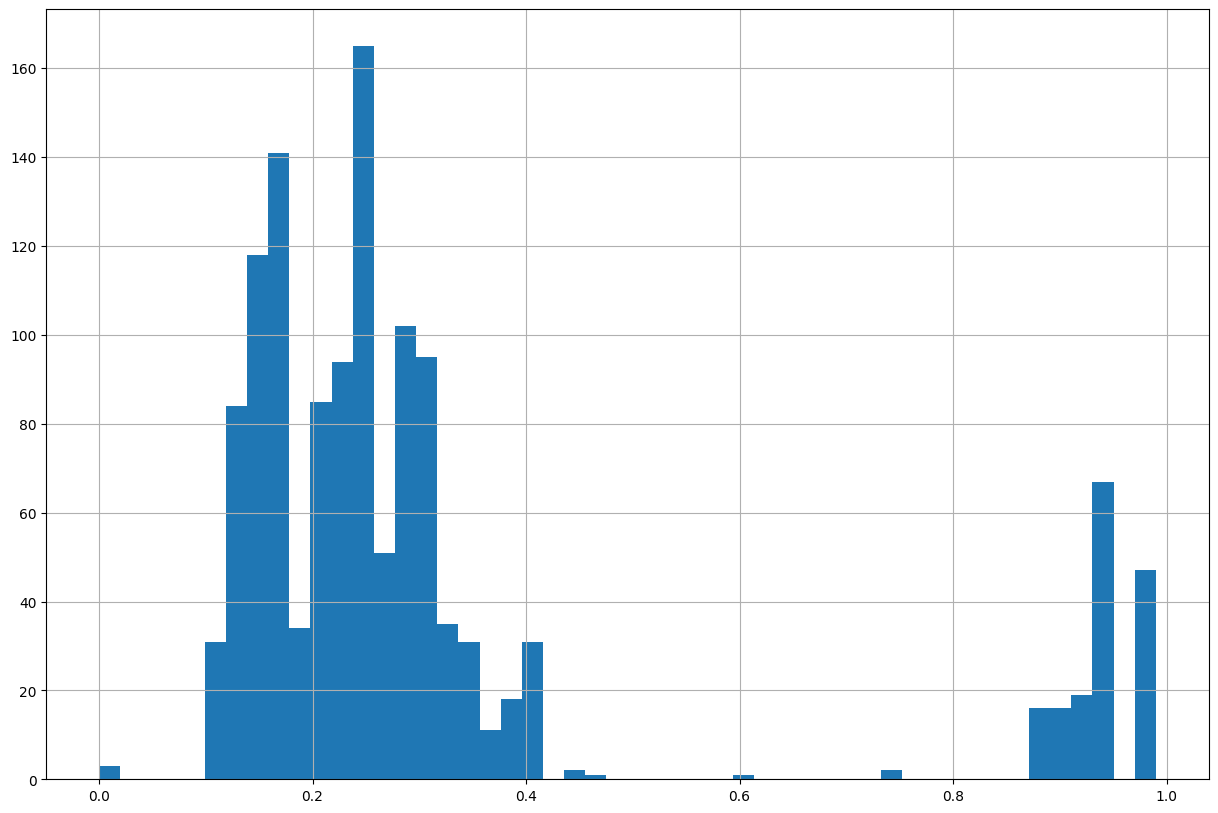

In [29]:
market_file.акционные_покупки.hist(bins = 50, figsize = (15,10));

Данные о среднемесячной доли покупок по акции от общего числа покупок за последние 6 месяцев деляться на 2 группы,тех кто покупает до 50% от общего числа покупок и тех кто более 90% покупает по акции,от общего числа покупок.

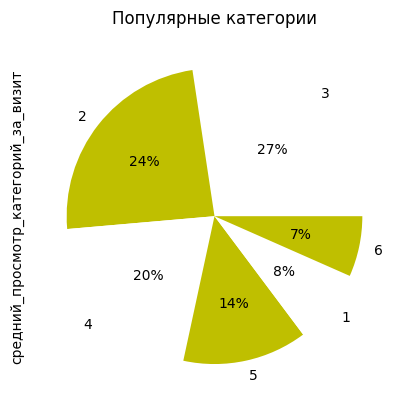

In [30]:
market_file['средний_просмотр_категорий_за_визит'].value_counts().plot(
    title='Популярные категории', 
    kind='pie', autopct='%1.0f%%', colors={'w', 'y'});

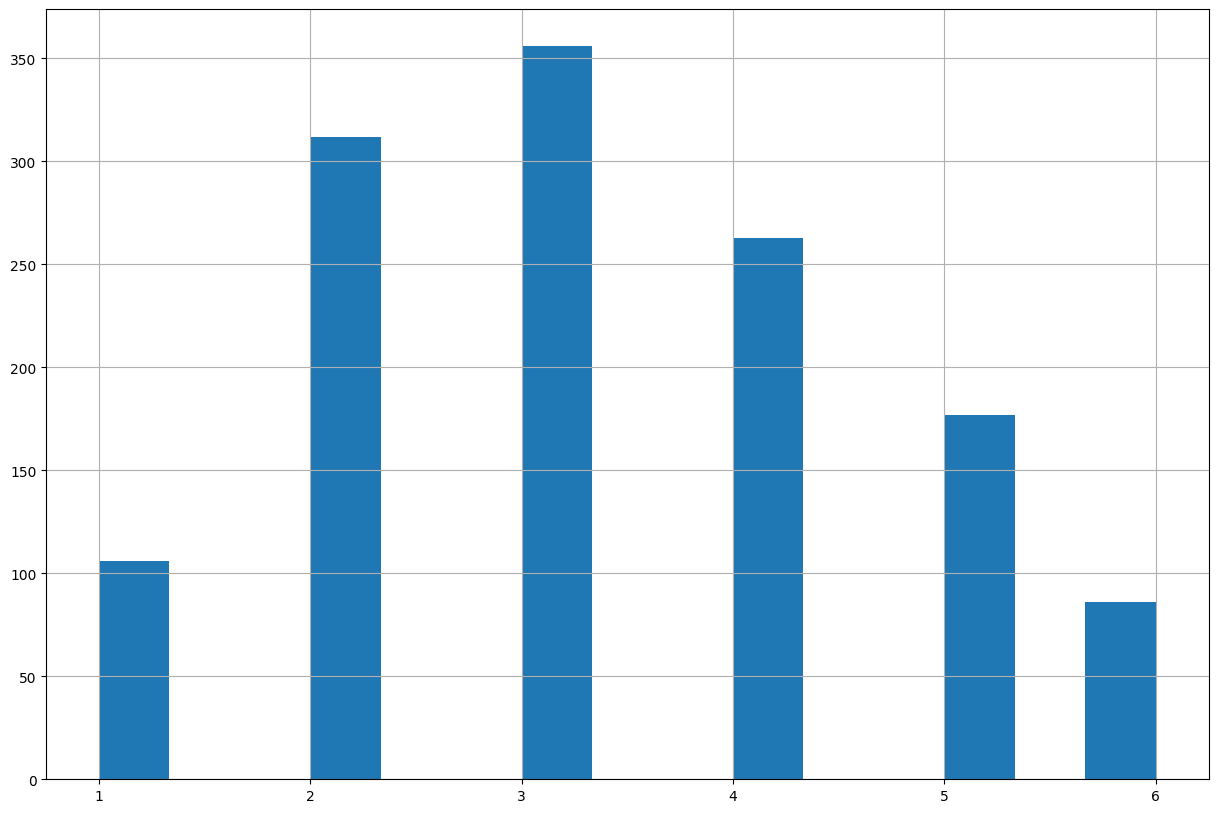

In [31]:
market_file.средний_просмотр_категорий_за_визит.hist(bins = 15, figsize = (15,10));

Более 350 пользователей просматривает в среднем 3 категории за визит, менее 100 человек просматривает в среднем все 6 категорий товаров.

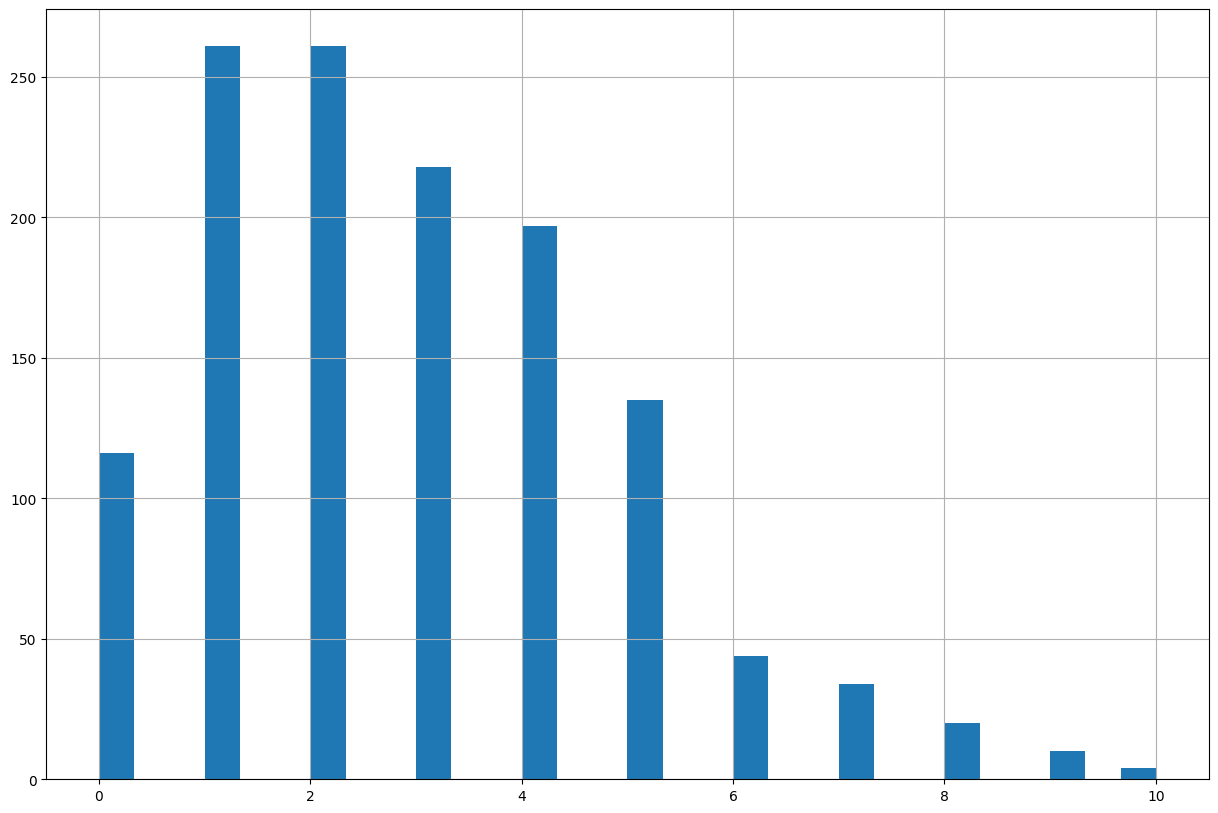

In [32]:
market_file.неоплаченные_продукты_штук_квартал.hist(bins = 30, figsize = (15,10));

Больше всего окупателей, не оплативших от 1 до 4 товаров в корзине.

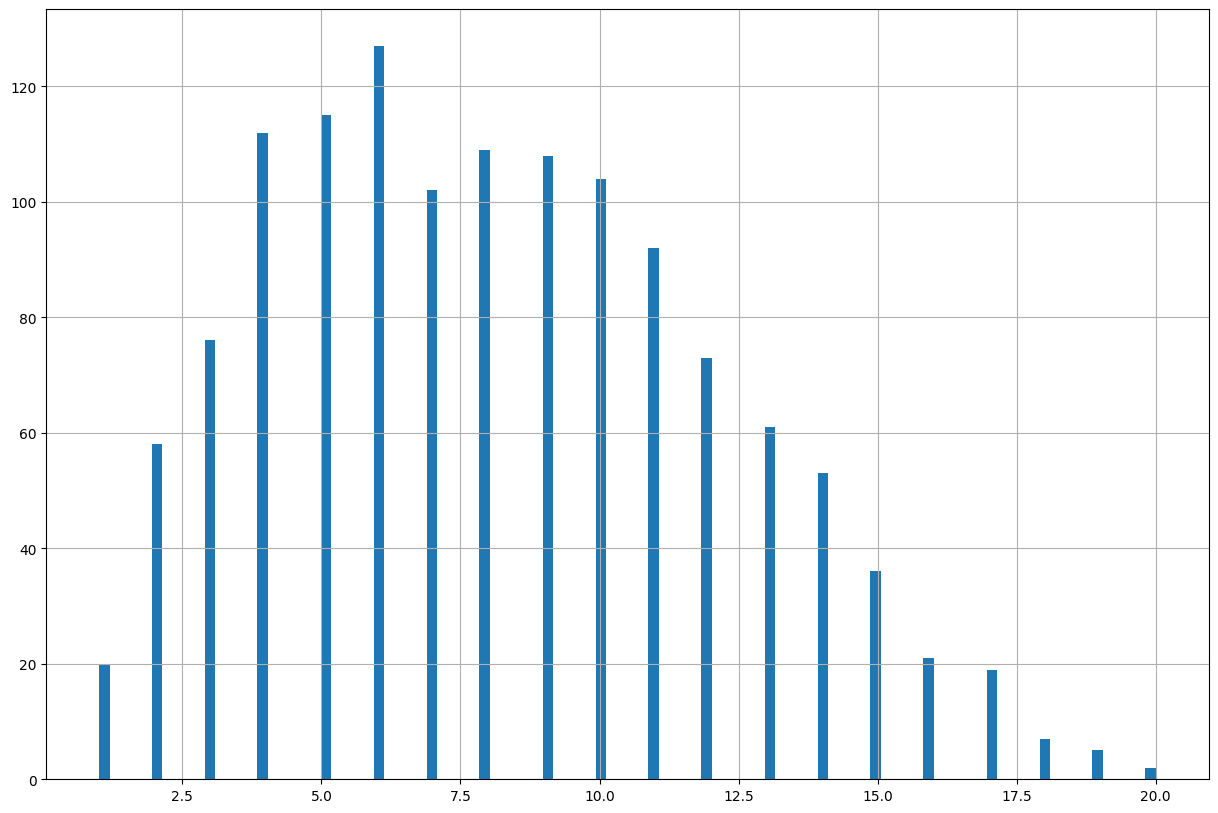

In [33]:
market_file.страниц_за_визит.hist(bins = 100, figsize = (15,10));

Среднее количество страниц, которые просмотрели покупатели за один визит на сайт за последние 3 месяца варьируется от 1 до 20 и большее количество находится в диапазоне от 4 до 11.

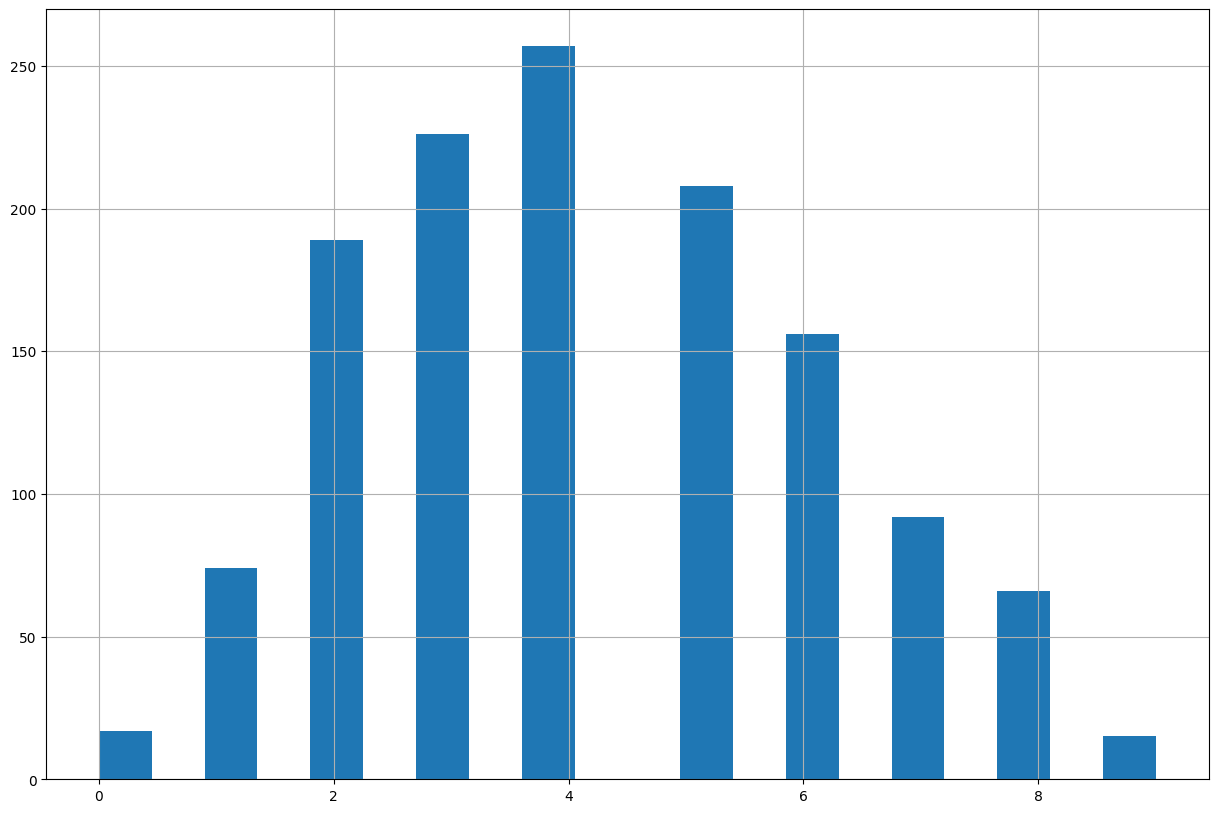

In [34]:
market_file.ошибка_сервиса.hist(bins = 20, figsize = (15,10));

Число сбоев, которые коснулись покупателя во время посещения сайта варьируется от 1 до 9, с большими показателями от 2 до 5.

In [35]:
market_money.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,3900.0,NaN,NaN,NaN,215997.5,375.325686,215348.0,215672.75,215997.5,216322.25,216647.0
период,3900,3,текущий_месяц,1300,NaN,NaN,NaN,NaN,NaN,NaN,NaN
выручка,3900.0,NaN,NaN,NaN,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.0,106862.2


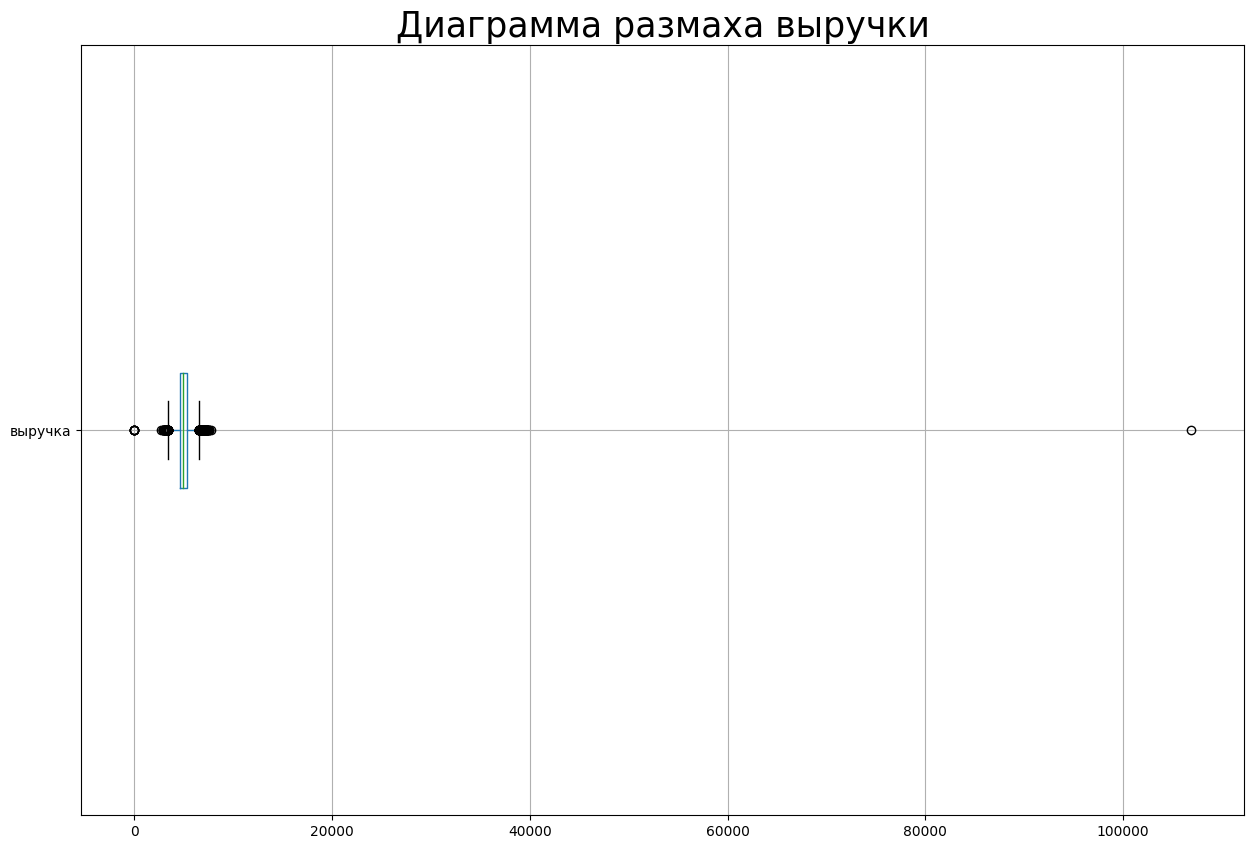

In [36]:
market_money.boxplot(column=['выручка'], figsize=(15,10), grid=True, vert=False)
plt.title('Диаграмма размаха выручки', size=25);
plt.show()

In [37]:
market_money.query('выручка < 1 | выручка > 8000')

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0
98,215380,текущий_месяц,106862.2


Встолбце *выручка* имеется аномальное значение,которое выбивается из общей массы.Так же есть нулевые значения,надо их изучить подробнее.

In [38]:
 market_money.query('id == 215348 | id == 215357 |id == 215359 | id == 215380')

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
27,215357,текущий_месяц,5986.3
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
33,215359,текущий_месяц,4735.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0
96,215380,препредыдущий_месяц,5051.0


Нулевые значения присутствуют только в определенный период у каждого пользователя,видимо это новые пользователи, ниже их удалю и не буду включать в обучение.

In [39]:
market_money.loc[market_money['выручка'] >= 10000, 'выручка'] = market_money['выручка'].mean()

Аномально высокое значени заменил на среднее значение столбца *выручка*.

In [40]:
market_time_1 = market_time.query('период == "предыдущий_месяц"')

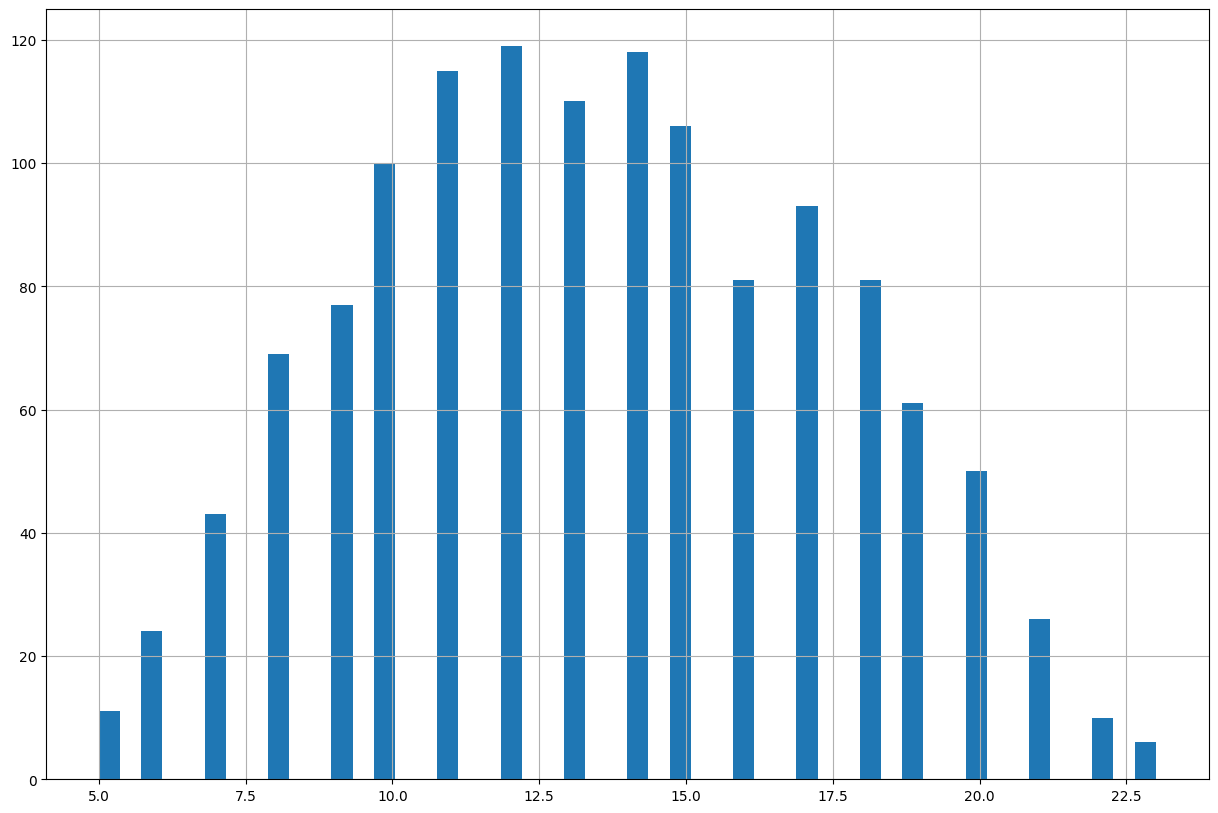

In [41]:
market_time_1.минут.hist(bins = 50, figsize = (15,10));

In [42]:
market_time_2 = market_time.query('период == "текущий_месяц"')

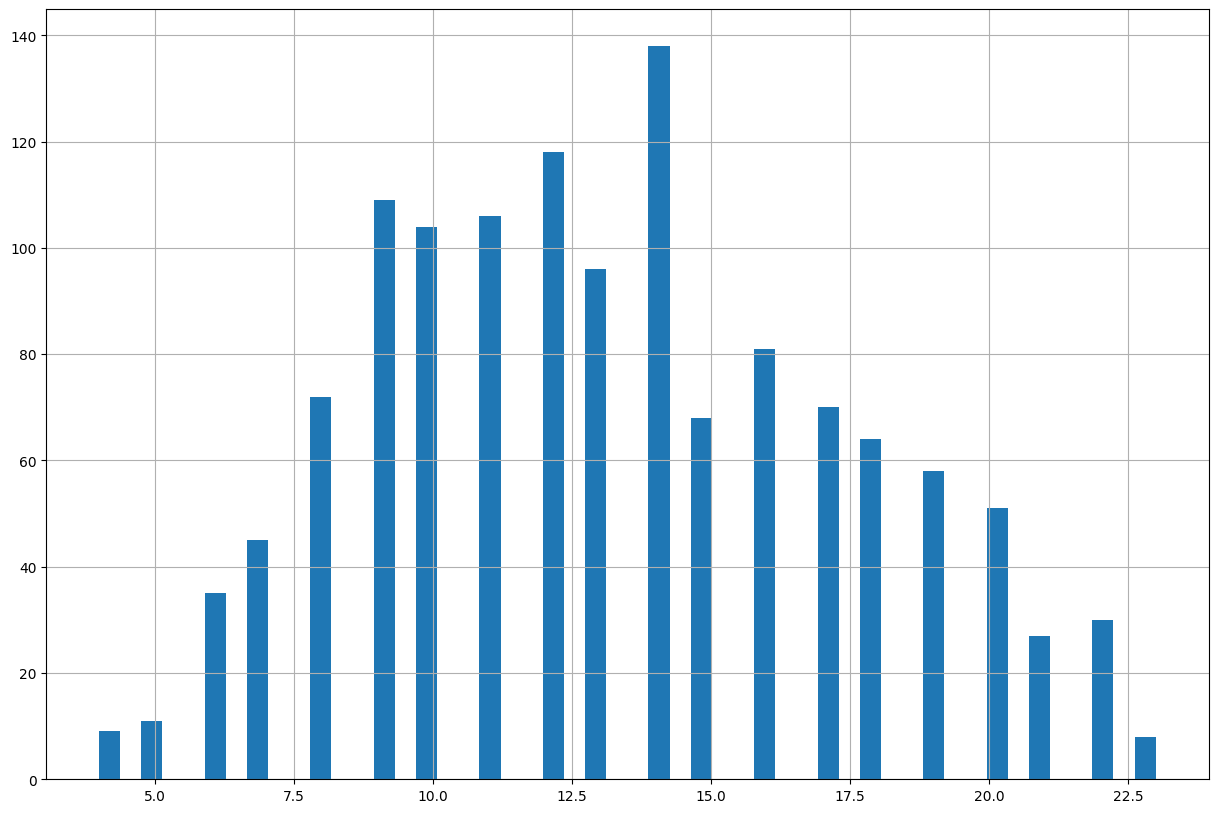

In [43]:
market_time_2.минут.hist(bins = 50, figsize = (15,10));

In [44]:
market_time_1.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,1300.0,NaN,NaN,NaN,215997.5,375.421985,215348.0,215672.75,215997.5,216322.25,216647.0
период,1300,1,предыдущий_месяц,1300,NaN,NaN,NaN,NaN,NaN,NaN,NaN
минут,1300.0,NaN,NaN,NaN,13.467692,3.932029,5.0,11.0,13.0,17.0,23.0


In [45]:
market_time_2.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,1300.0,NaN,NaN,NaN,215997.5,375.421985,215348.0,215672.75,215997.5,216322.25,216647.0
период,1300,1,текущий_месяц,1300,NaN,NaN,NaN,NaN,NaN,NaN,NaN
минут,1300.0,NaN,NaN,NaN,13.204615,4.220589,4.0,10.0,13.0,16.0,23.0


Во все периоды примерно одинаковое значение времени от 4-5 до 23 со средним 13.

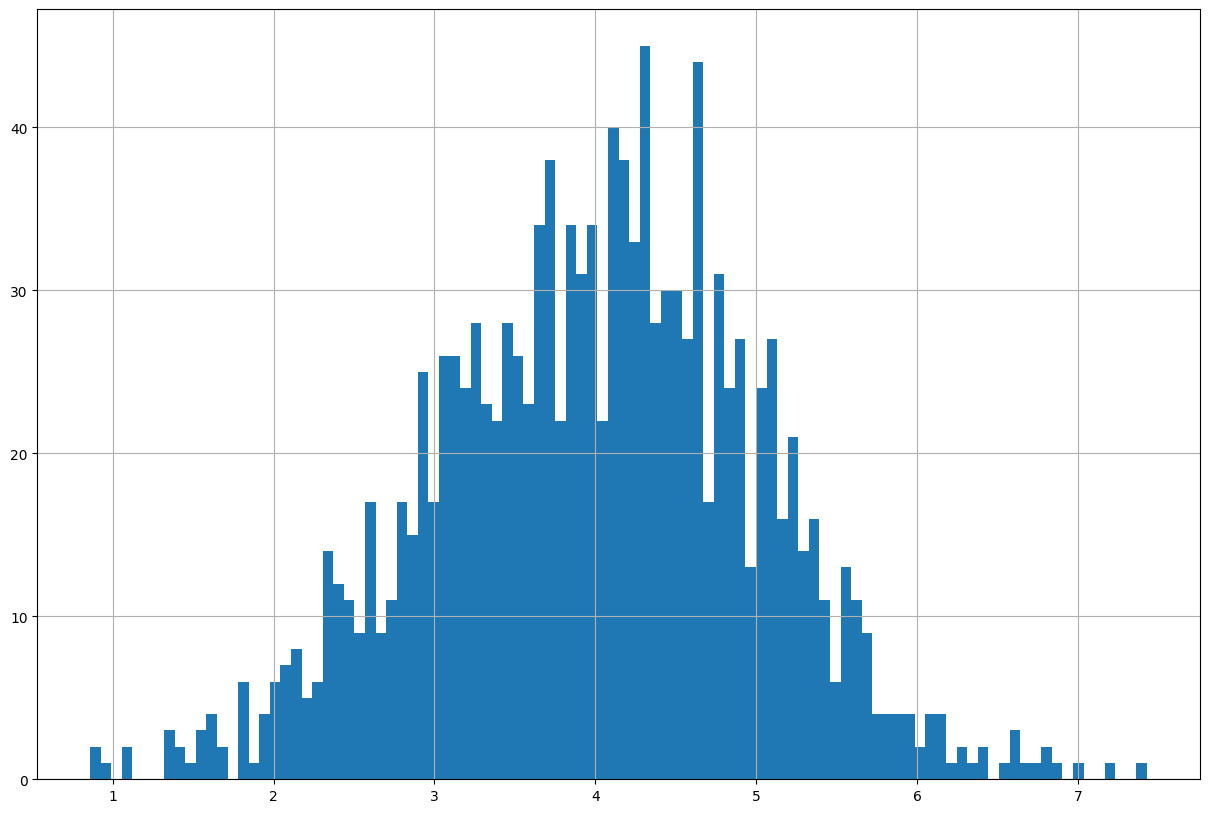

In [46]:
money.прибыль.hist(bins = 100, figsize = (15,10));

In [47]:
money.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.00,215672.75,215997.500,216322.25,216647.00
прибыль,1300.0,3.996631,1.013722,0.86,3.30,4.045,4.67,7.43


В таблице *money* распределение нормальное со среднимв районе 4.

### Отберите клиентов с покупательской активностью не менее трёх месяцев

In [48]:
market_money = market_money.query('выручка > 0')
f = market_money['id'].value_counts()
f.loc[ lambda x : x >= 3]

215349    3
215756    3
215792    3
215790    3
215788    3
         ..
216215    3
216213    3
216211    3
216209    3
216207    3
Name: id, Length: 1297, dtype: int64

In [49]:
market_money = market_money.query('id != 215348 & id != 215357 & id != 215359')
market_file = market_file.query('id != 215348 & id != 215357 & id != 215359')
market_time = market_time.query('id != 215348 & id != 215357 & id != 215359')

**Вывод:** Отобрал клиентов, купивших товар в каждом из 3 месяцев, их колличество 1297 человек.

## Объединение таблиц

In [50]:
market_money_1 = (market_money
                           .query('период == "текущий_месяц"')
                           .drop(['период'], axis=1)
                           .rename(columns={'выручка': 'выручка_текущий_месяц'}))

market_money_2 = (market_money
                           .query('период == "предыдущий_месяц"')
                           .drop(['период'], axis=1)
                           .rename(columns={'выручка': 'выручка_предыдущий_месяц'}))

market_money_3 = (market_money
                              .query('период == "препредыдущий_месяц"')
                              .drop(['период'], axis=1)
                              .rename(columns={'выручка': 'выручка_предпредыдущий_месяц'}))

market_time_1 = (market_time
                          .query('период == "текущий_месяц"')
                          .drop(['период'], axis=1)
                          .rename(columns={'минут': 'время_текущий_месяц'}))

market_time_2 = (market_time
                          .query('период == "предыдущий_месяц"')
                          .drop(['период'], axis=1)
                          .rename(columns={'минут': 'время_предыдущий_месяц'}))

In [51]:
df_market = market_file.merge(market_money_1, on = 'id', how  ='outer')
df_market = df_market.merge(market_money_2, on = 'id', how  ='outer')
df_market = df_market.merge(market_money_3, on = 'id', how  ='outer')
df_market = df_market.merge(market_time_1, on = 'id', how  ='outer')
df_market = df_market.merge(market_time_2, on = 'id', how  ='outer')

df_market.head()                              

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_текущий_месяц,выручка_предыдущий_месяц,выручка_предпредыдущий_месяц,время_текущий_месяц,время_предыдущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,4472.0,10,12
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,4826.0,13,8
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,4793.0,13,11
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,5807.5,4594.0,11,8
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5388.5,4738.5,5124.0,10,10


Объединил таблицы market_file.csv, market_money.csv, market_time.csv и разбил на  отдельные столбцы столбец *период* по выручке и времени.

## Корреляционный анализ

interval columns not set, guessing: ['id', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_текущий_месяц', 'выручка_предыдущий_месяц', 'выручка_предпредыдущий_месяц', 'время_текущий_месяц', 'время_предыдущий_месяц']


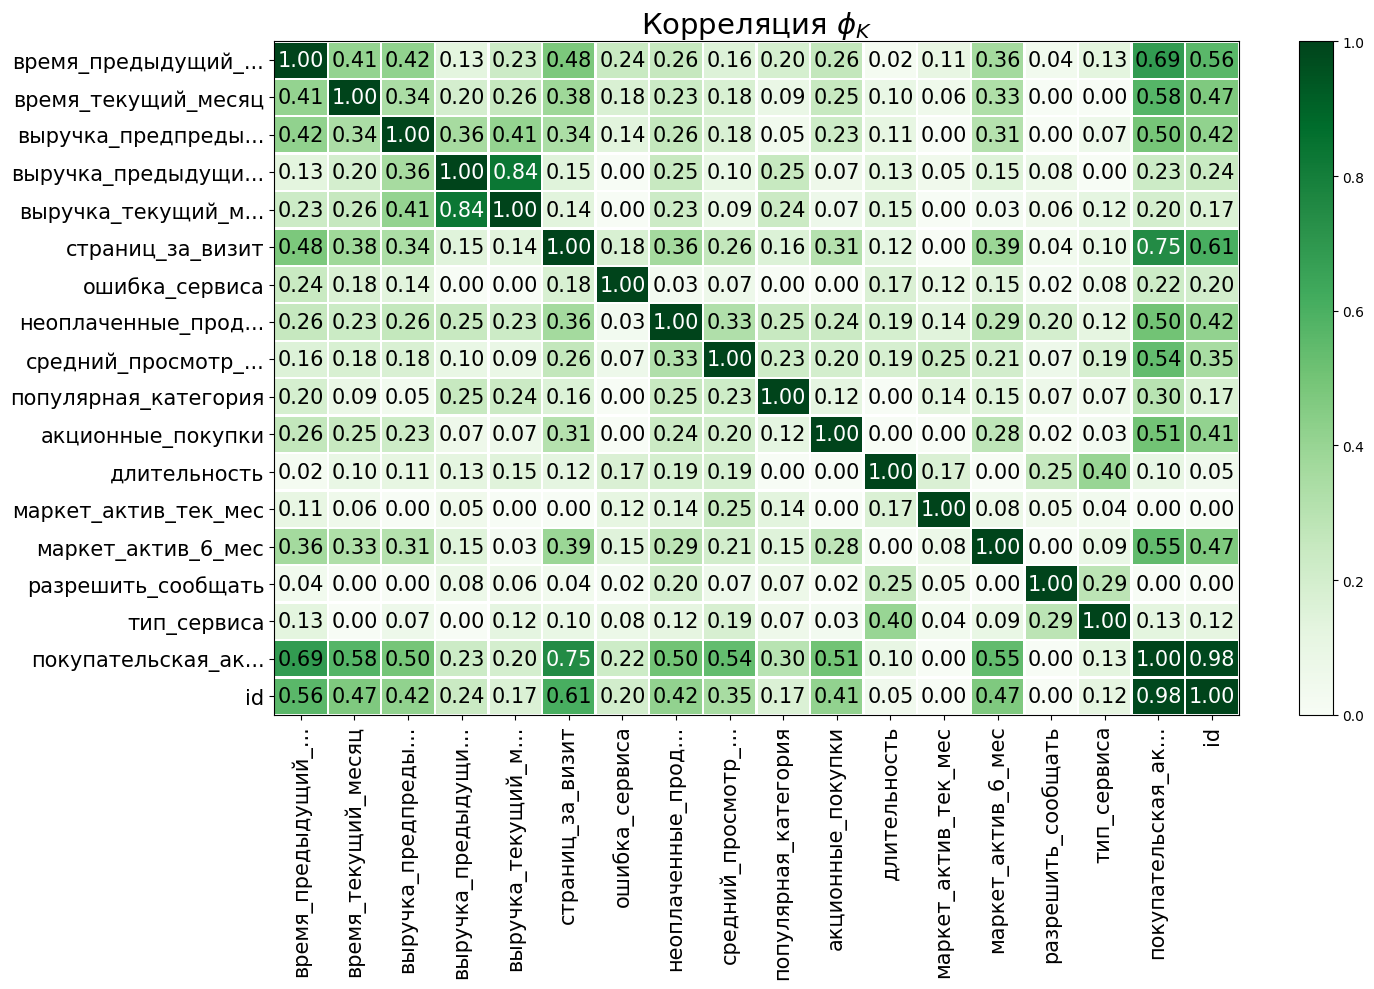

In [52]:
phik_overview = df_market.phik_matrix()

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Корреляция $\phi_K$',
    fontsize_factor=1.5,
    figsize=(15, 10)
) ;

**Вывод:** Сильная зависимость у столбцов *id* и покупательская_активность, при разделении df удалю его.Так же зависимость наблюдаем между предыдущим периодом выручки и текущим, между покупательской активностью количество страниц за визит и времени за предыдущий месяц.  

## Использование пайплайнов

In [53]:
df_market['покупательская_активность'] = df_market['покупательская_активность'].apply(lambda x: 1 if x == 'Снизилась' else 0)

In [54]:
df_market['покупательская_активность'].unique()

array([1, 0], dtype=int64)

Заменил значения в целевом признаке на 1 и 0.

In [55]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X = df_market.drop(columns=['покупательская_активность', 'id'])
y = df_market['покупательская_активность']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE, 
    test_size=TEST_SIZE, 
    stratify=y
) 

In [56]:
y_test

1095    0
118     1
950     0
362     1
149     1
       ..
217     1
768     0
153     1
1196    0
47      1
Name: покупательская_активность, Length: 325, dtype: int64

In [57]:
for i in [X_train, X_test, y_train, y_test]:
    print(i.shape)

(972, 16)
(325, 16)
(972,)
(325,)


Разделил df на целовой признак и признаки,
использовал стратификацию.

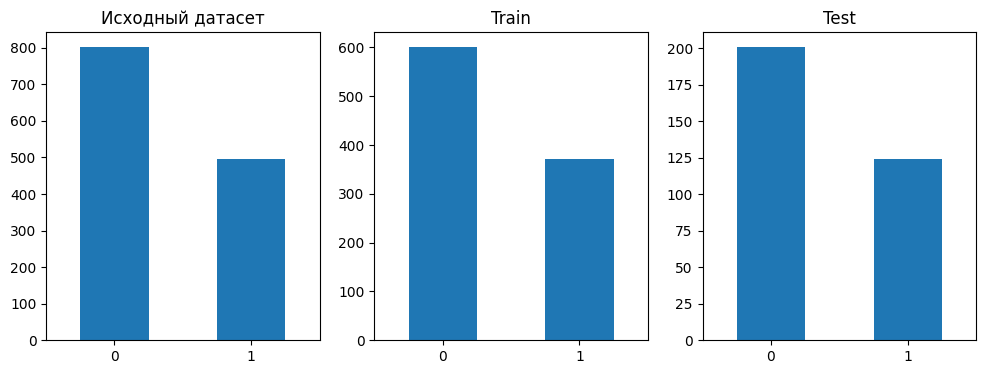

In [58]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
y.value_counts().plot(kind='bar', ax=ax[0], rot=0)
ax[0].set_title("Исходный датасет")
y_train.value_counts().plot(kind='bar', ax=ax[1], rot=0)
ax[1].set_title("Train")
y_test.value_counts().plot(kind='bar', ax=ax[2], rot=0)
ax[2].set_title("Test")
plt.show()

Создам пайплайн, который выберет лучшую комбинацию модели и гиперпараметров. Использую модели:
- DecisionTreeClassifier()с гиперпараметрами max_depth от 2 до 4 включительно и max_features от 2 до 4 включительно
- SVC(kernel='linear', probability= True)
- KNeighborsClassifier() с гиперпараметром n_neighbors от 2 до 4 включительно
- LogisticRegression(solver='liblinear', penalty='l1') с гиперпараметром регуляризации С от 1 до 4 включительно.
Так же использую два маштабирования StandardScaler()и MinMaxScaler(),OrdinalEncoder() для столбца *тип_сервиса* и OHE для остальных.

In [59]:
ohe_columns = ['популярная_категория', 'разрешить_сообщать']

ord_columns = ['тип_сервиса']

num_columns = ['маркет_актив_6_мес', 
               'маркет_актив_тек_мес', 
               'длительность', 
               'акционные_покупки', 
               'средний_просмотр_категорий_за_визит', 
               'неоплаченные_продукты_штук_квартал', 
               'ошибка_сервиса', 
               'страниц_за_визит', 
               'выручка_текущий_месяц', 
               'выручка_предыдущий_месяц', 
               'выручка_предпредыдущий_месяц', 
               'время_текущий_месяц', 
               'время_предыдущий_месяц']

In [60]:
ohe_pipe = Pipeline([('ohe', OneHotEncoder(drop='first', sparse_output=False))]) 

In [61]:
ord_pipe = Pipeline([('ord',  OrdinalEncoder(categories=[['премиум', 'стандарт']]))]) 

In [62]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [63]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [64]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features':  range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(
            kernel='linear',
            random_state=RANDOM_STATE,
            probability= True,
        )],
        'models__C': range(1, 5),
        
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]


In [65]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train) ;

Использовав пайплан,выявил лучшую модель на тренировочной выборке,выбрал метрику roc_auc, потомучто учитывает не только результаты классификации, но и вероятность предсказания всех классов, она учитывает работу модели при всех возможных значениях порогов и поэтому не зависит от одного конкретного. 

In [66]:
print('Метрика ROC-AUC для лучшей модели:\n', randomized_search.best_score_)
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Метрика ROC-AUC для лучшей модели:
 0.8978859777132504

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория',
                                                   'разрешить_сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['премиум',
                                                                                               'стан

In [67]:
pd.set_option('display.max_colwidth', None)
pd.DataFrame(randomized_search.cv_results_)[
    ['std_test_score', 'rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')

,std_test_score,rank_test_score,param_models,mean_test_score,params
7,0.021416,1,"LogisticRegression(penalty='l1', random_state=42, solver='liblinear')",0.897886,"{'preprocessor__num': StandardScaler(), 'models__C': 1, 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}"
5,0.021679,2,"LogisticRegression(penalty='l1', random_state=42, solver='liblinear')",0.897706,"{'preprocessor__num': StandardScaler(), 'models__C': 3, 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}"
9,0.021549,3,"LogisticRegression(penalty='l1', random_state=42, solver='liblinear')",0.897348,"{'preprocessor__num': StandardScaler(), 'models__C': 4, 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}"
3,0.024883,4,KNeighborsClassifier(),0.894803,"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 4, 'models': KNeighborsClassifier()}"
2,0.025669,5,"SVC(kernel='linear', probability=True, random_state=42)",0.892914,"{'preprocessor__num': StandardScaler(), 'models__C': 4, 'models': SVC(kernel='linear', probability=True, random_state=42)}"
6,0.025627,6,"SVC(kernel='linear', probability=True, random_state=42)",0.892803,"{'preprocessor__num': StandardScaler(), 'models__C': 3, 'models': SVC(kernel='linear', probability=True, random_state=42)}"
4,0.027745,7,DecisionTreeClassifier(random_state=42),0.796997,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 3, 'models__max_depth': 3, 'models': DecisionTreeClassifier(random_state=42)}"
8,0.027745,7,DecisionTreeClassifier(random_state=42),0.796997,"{'preprocessor__num': StandardScaler(), 'models__max_features': 3, 'models__max_depth': 3, 'models': DecisionTreeClassifier(random_state=42)}"
0,0.030929,9,DecisionTreeClassifier(random_state=42),0.747412,"{'preprocessor__num': StandardScaler(), 'models__max_features': 2, 'models__max_depth': 2, 'models': DecisionTreeClassifier(random_state=42)}"
1,0.026214,10,DecisionTreeClassifier(random_state=42),0.734251,"{'preprocessor__num': 'passthrough', 'models__max_features': 3, 'models__max_depth': 2, 'models': DecisionTreeClassifier(random_state=42)}"


In [68]:
pd.DataFrame(randomized_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__max_features,param_models__max_depth,param_models,param_models__C,param_models__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.029989,0.003411,0.016805,0.004623,StandardScaler(),2,2,DecisionTreeClassifier(random_state=42),NaN,NaN,"{'preprocessor__num': StandardScaler(), 'models__max_features': 2, 'models__max_depth': 2, 'models': DecisionTreeClassifier(random_state=42)}",0.703652,0.786278,0.729167,0.739527,0.778435,0.747412,0.030929,9
1,0.028798,0.004915,0.014003,0.002524,passthrough,3,2,DecisionTreeClassifier(random_state=42),NaN,NaN,"{'preprocessor__num': 'passthrough', 'models__max_features': 3, 'models__max_depth': 2, 'models': DecisionTreeClassifier(random_state=42)}",0.739446,0.758611,0.696565,0.712218,0.764414,0.734251,0.026214,10
2,0.359597,0.055132,0.013603,0.001020,StandardScaler(),NaN,NaN,"SVC(kernel='linear', probability=True, random_state=42)",4,NaN,"{'preprocessor__num': StandardScaler(), 'models__C': 4, 'models': SVC(kernel='linear', probability=True, random_state=42)}",0.877597,0.905556,0.921734,0.909234,0.850450,0.892914,0.025669,5
3,0.021214,0.000750,0.162799,0.006110,StandardScaler(),NaN,NaN,KNeighborsClassifier(),NaN,4,"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 4, 'models': KNeighborsClassifier()}",0.912162,0.897722,0.915372,0.902027,0.846734,0.894803,0.024883,4
4,0.025800,0.003915,0.020597,0.008111,MinMaxScaler(),3,3,DecisionTreeClassifier(random_state=42),NaN,NaN,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 3, 'models__max_depth': 3, 'models': DecisionTreeClassifier(random_state=42)}",0.756310,0.836444,0.815766,0.780124,0.796340,0.796997,0.027745,7
5,0.027591,0.006119,0.016203,0.008932,StandardScaler(),NaN,NaN,"LogisticRegression(penalty='l1', random_state=42, solver='liblinear')",3,NaN,"{'preprocessor__num': StandardScaler(), 'models__C': 3, 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}",0.881617,0.913444,0.921959,0.907770,0.863739,0.897706,0.021679,2
6,0.244195,0.025164,0.010806,0.002136,StandardScaler(),NaN,NaN,"SVC(kernel='linear', probability=True, random_state=42)",3,NaN,"{'preprocessor__num': StandardScaler(), 'models__C': 3, 'models': SVC(kernel='linear', probability=True, random_state=42)}",0.877373,0.905111,0.921847,0.909122,0.850563,0.892803,0.025627,6
7,0.029400,0.011856,0.011007,0.000638,StandardScaler(),NaN,NaN,"LogisticRegression(penalty='l1', random_state=42, solver='liblinear')",1,NaN,"{'preprocessor__num': StandardScaler(), 'models__C': 1, 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}",0.882287,0.913111,0.922072,0.907770,0.864189,0.897886,0.021416,1
8,0.018606,0.002414,0.011003,0.001547,StandardScaler(),3,3,DecisionTreeClassifier(random_state=42),NaN,NaN,"{'preprocessor__num': StandardScaler(), 'models__max_features': 3, 'models__max_depth': 3, 'models': DecisionTreeClassifier(random_state=42)}",0.756310,0.836444,0.815766,0.780124,0.796340,0.796997,0.027745,7
9,0.020995,0.001671,0.011807,0.000406,StandardScaler(),NaN,NaN,"LogisticRegression(penalty='l1', random_state=42, solver='liblinear')",4,NaN,"{'preprocessor__num': StandardScaler(), 'models__C': 4, 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}",0.881729,0.912556,0.921734,0.907320,0.863401,0.897348,0.021549,3


Лучшей моделью получилась LogisticRegression(penalty='l1', random_state=42, solver='liblinear') с гиперпараметром регуляризации С=1.

In [69]:
ohe_encoder = OneHotEncoder(sparse_output=False, drop='first')
X_train_ohe = ohe_encoder.fit_transform(X_train[ohe_columns])
X_test_ohe = ohe_encoder.transform(X_test[ohe_columns])
ohe_encoder_col_names = ohe_encoder.get_feature_names_out()

ord_encoder = OrdinalEncoder()
X_train_ord = ord_encoder.fit_transform(X_train[ord_columns])
X_test_ord = ord_encoder.transform(X_test[ord_columns])
ord_encoder_col_names = ord_encoder.get_feature_names_out()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe_encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe_encoder_col_names)

X_train_ord = pd.DataFrame(X_train_ord, columns=ord_encoder_col_names)
X_test_ord = pd.DataFrame(X_test_ord, columns=ord_encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)

X_train_total = pd.concat([X_train_ohe, X_train_ord, X_train_scaled], axis=1)

X_test_total = pd.concat([X_test_ohe, X_test_ord, X_test_scaled], axis=1)

In [70]:
for i in [X_train_total, X_test_total, y_train, y_test]:
    print(i.shape)

(972, 20)
(325, 20)
(972,)
(325,)


In [71]:
clf =  LogisticRegression(penalty='l1', random_state=42, solver='liblinear', C=1) 
clf.fit(X_train_total, y_train)
y_pred = clf.predict(X_test_total)

clf_probas = clf.predict_proba(X_test_total)[:,1]

print('Метрики модели:')
roc_auc_cv = cross_val_score(clf, X_train_total, y_train, scoring='roc_auc').mean()
print(f'ROC-AUC на тренировочной выборке: {round(roc_auc_cv, 3)}')
print(f'ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, clf_probas), 3)}')

clf_best_acc = accuracy_score(y_test, y_pred)
print('Accuracy:', round(clf_best_acc, 3))

clf_best_f1 = f1_score(y_test, y_pred, pos_label=1)
print('F1-score:', round(clf_best_f1, 3))

Метрики модели:
ROC-AUC на тренировочной выборке: 0.898
ROC-AUC на тестовой выборке: 0.923
Accuracy: 0.908
F1-score: 0.873


Обучил модель LogisticRegression() с лучшими параметрами на тестовой выборки, результаты не сильно отличаются от тренировочной, так же *Accuracy* и *F1-score* довольно хорошие

In [72]:
confusion_matrix= confusion_matrix(y_test, y_pred)

confusion_matrix

array([[192,   9],
       [ 21, 103]], dtype=int64)

Построил матрицу ошибок:
- класс 0 = 192 
- класс 1 = 103
- ошибка False Negative = 21
- ошибка False Positive = 9 

In [73]:
# импорт класса дамми-модели 
from sklearn.dummy import DummyClassifier

# создание и обучение модели DummyClassifier 
dummy_model = DummyClassifier(random_state=RANDOM_STATE)
dummy_model.fit(X_train_total, y_train)

# предсказание на тестовых данных
dummy_model_preds = dummy_model.predict(X_test_total)
dummy_model_probas = dummy_model.predict_proba(X_test_total)[:,1]

# оценка качества модели по метрике accuracy
dummy_acc = accuracy_score(y_test, dummy_model_preds)
print('Model Accuracy =', round(dummy_acc, 2))

dummy_roc = roc_auc_score(y_test, dummy_model_probas)
print('ROC-AUC =', round(dummy_roc,2))

# посчитайте и выведите F1-меру
dummy_f1 = f1_score(y_test, dummy_model_preds, pos_label=1)
print('F1-score =', round(dummy_f1,2))

Model Accuracy = 0.62
ROC-AUC = 0.5
F1-score = 0.0


Проверил модель на адекватность. Метрики модели LogisticRegression() лучше чем DummyClassifier()

## Анализ важности признаков

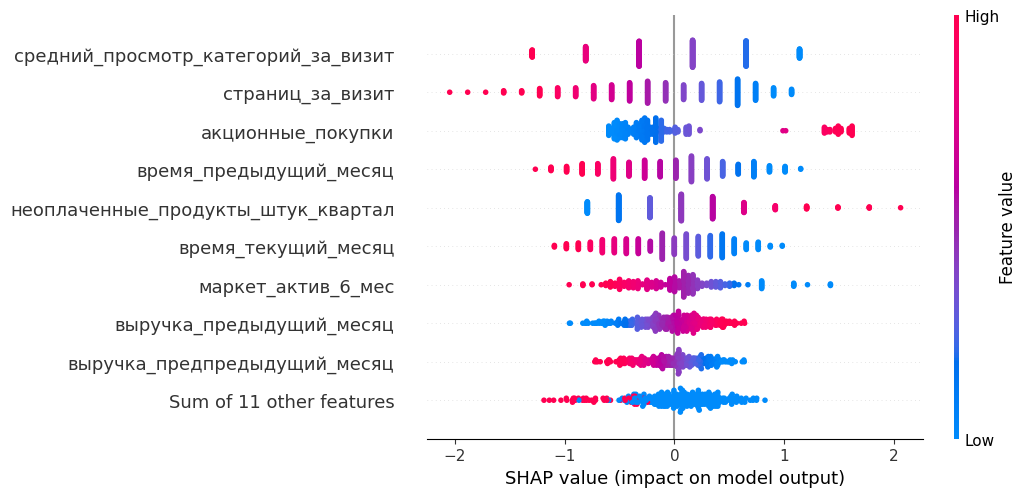

In [74]:
explainer = shap.LinearExplainer(clf, X_test_total)
shap_values = explainer(X_test_total)

shap.plots.beeswarm(shap_values) 

Большое влияние оказывает признак *страниц_за_визит*,негативные значения Шепли слева от центральной вертикальной линии означают, что признак склоняет модель отнести объекты к классу 0(такой признаки как *акционные_покупки*), а положительные справа — к классу 1(такой признак как *маркет_актив_6_мес*), остальные 11 признаков склоняют к классу 1

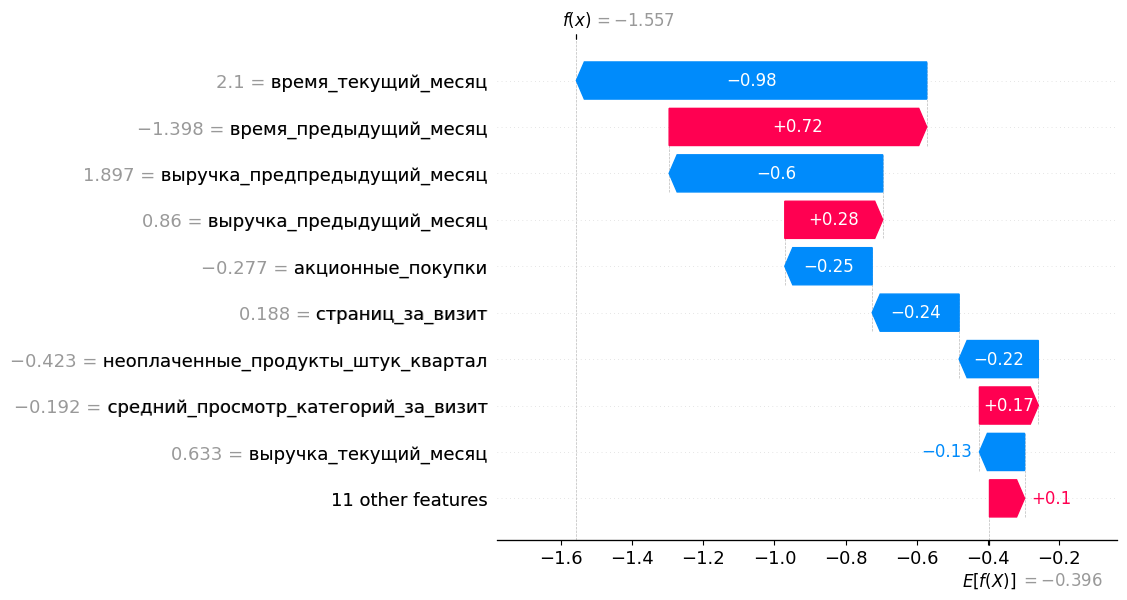

In [75]:
shap.plots.waterfall(shap_values[5]) 

Сильнее всего на классификацию влияет признак *время_текущий_месяц* и перетягивает предсказание в сторону класса 0,далее идет время_предыдущий_месяц и перетягивает предсказание в сторону класса 1. Значение f(x)=-1,496 на графике показывает, что наблюдение скорее относится к классу 0

In [76]:
# shap.plots.bar(shap_values)

## Сегментация покупателей

In [77]:
clf_best_probas_train = clf.predict_proba(X_train_total)[:,1]

X_pred = clf.predict(X_train_total)

total_train = pd.concat([X_train, y_train], axis=1)
total_test = pd.concat([X_test, y_test], axis=1)

total_train['predict_proba'] = clf_best_probas_train.tolist()
total_train['прогноз_активности'] = X_pred.tolist()
total_test['predict_proba'] = clf_probas.tolist()
total_test['прогноз_активности'] = y_pred.tolist()

final_df = pd.concat([total_train, total_test])
final_df = pd.merge(final_df, df_market['id'], left_index=True, right_index=True)

final_df['покупательская_активность'] = df_market['покупательская_активность'].apply(lambda x: 'cнизилась' if x == 1 else 'прежний уровень')

final_df['прогноз_активности'] = final_df['прогноз_активности'].astype(int)
final_df['прогноз_активности'] = final_df['прогноз_активности'].apply(lambda x: 'cнизится' if x == 1 else 'прежний уровень')

final_df = final_df.merge(money, on='id')

display(final_df.head(10))
final_df.info()

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,...,выручка_текущий_месяц,выручка_предыдущий_месяц,выручка_предпредыдущий_месяц,время_текущий_месяц,время_предыдущий_месяц,покупательская_активность,predict_proba,прогноз_активности,id,прибыль
0,стандарт,да,5.5,4,510,0.15,Мелкая бытовая техника и электроника,2,4,7,...,6014.2,5170.5,4347.0,6,20,прежний уровень,0.076803,прежний уровень,215858,4.37
1,стандарт,да,5.1,4,199,0.23,Техника для красоты и здоровья,4,5,2,...,3789.7,6400.0,4597.0,13,11,cнизилась,0.776534,cнизится,215361,4.03
2,стандарт,да,4.3,5,997,0.17,Мелкая бытовая техника и электроника,5,1,3,...,3798.4,4113.0,4626.0,10,13,прежний уровень,0.067285,прежний уровень,215884,4.37
3,премиум,да,3.7,3,1057,0.18,Домашний текстиль,4,3,4,...,5231.8,5133.0,5169.0,10,13,прежний уровень,0.341227,прежний уровень,216563,3.38
4,стандарт,да,3.8,5,694,0.40,Кухонная посуда,3,7,4,...,7063.0,5854.0,4864.0,9,13,cнизилась,0.896295,cнизится,215714,4.85
5,стандарт,нет,5.1,3,904,0.26,Мелкая бытовая техника и электроника,4,1,2,...,4630.0,4279.0,4534.0,20,14,прежний уровень,0.022090,прежний уровень,216606,3.09
6,стандарт,нет,2.4,5,340,0.40,Домашний текстиль,1,5,1,...,4458.9,4604.5,4105.0,11,8,cнизилась,0.992692,cнизится,215673,4.55
7,премиум,да,6.1,3,1056,0.17,Домашний текстиль,2,3,7,...,4423.0,4767.5,5315.0,17,15,прежний уровень,0.142455,прежний уровень,216334,4.84
8,стандарт,да,4.3,4,831,0.21,Мелкая бытовая техника и электроника,5,2,3,...,3287.0,3872.0,4697.0,17,11,прежний уровень,0.101529,прежний уровень,216186,6.29
9,премиум,да,5.7,4,713,0.13,Косметика и акссесуары,3,1,0,...,4965.4,4799.0,4757.0,18,13,прежний уровень,0.112144,прежний уровень,216525,4.60


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 0 to 1296
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   тип_сервиса                          1297 non-null   object 
 1   разрешить_сообщать                   1297 non-null   object 
 2   маркет_актив_6_мес                   1297 non-null   float64
 3   маркет_актив_тек_мес                 1297 non-null   int64  
 4   длительность                         1297 non-null   int64  
 5   акционные_покупки                    1297 non-null   float64
 6   популярная_категория                 1297 non-null   object 
 7   средний_просмотр_категорий_за_визит  1297 non-null   int64  
 8   неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 9   ошибка_сервиса                       1297 non-null   int64  
 10  страниц_за_визит                     1297 non-null   int64  
 11  выручка_текущий_месяц         

Добавил столбец *прогноз_активности*, *predict_proba*, он возвращает оценки вероятности для всех классов и таблицу с данными о среднемесячной прибыли магазина за последние 3 месяца

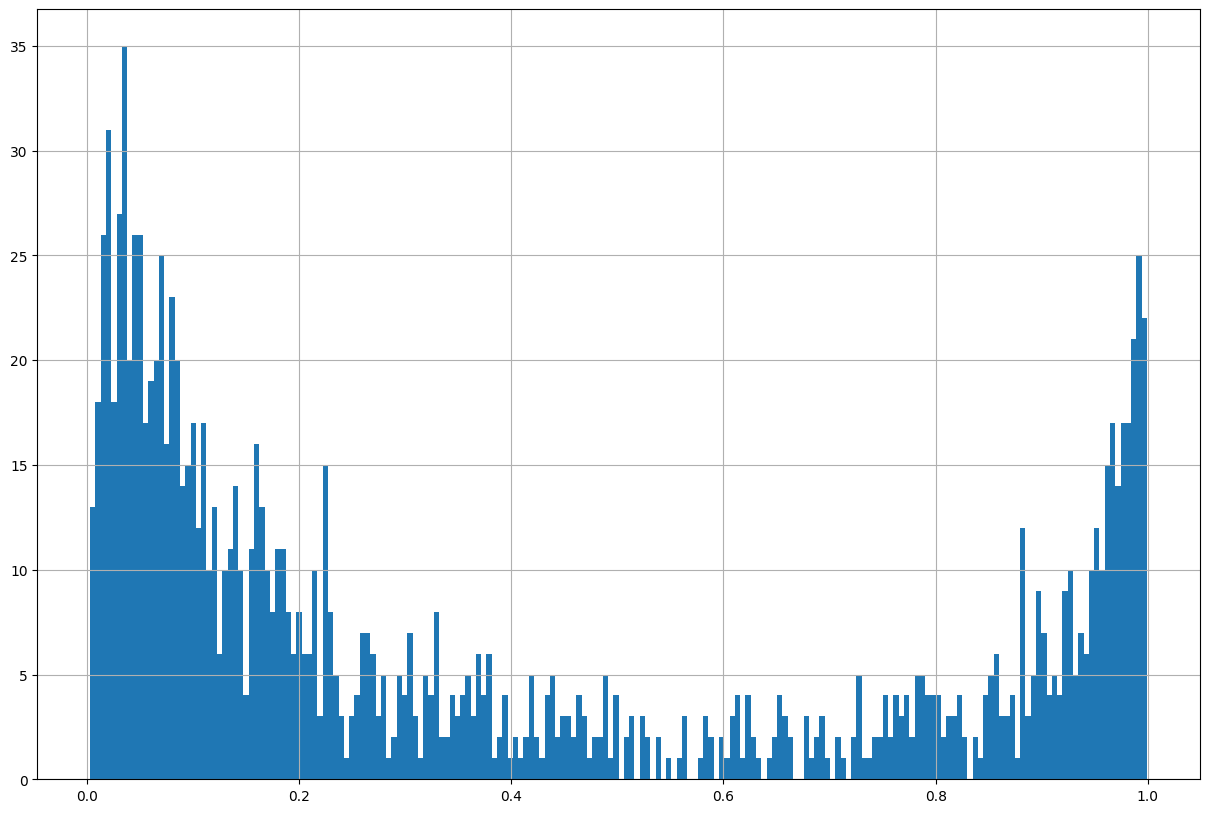

In [78]:
final_df.predict_proba.hist(bins = 200, figsize = (15,10));

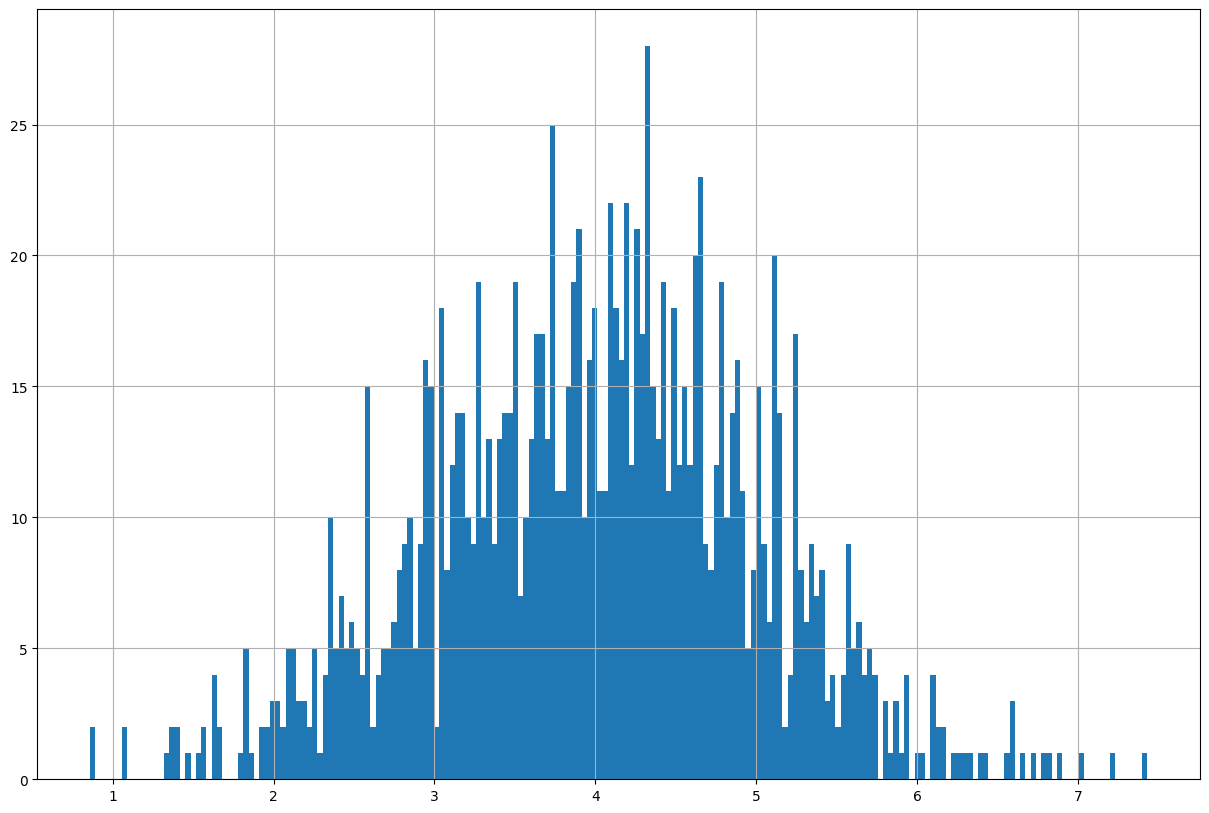

In [79]:
final_df.прибыль.hist(bins = 200, figsize = (15,10));

In [80]:
target_audience = final_df.query('прибыль > 4 & predict_proba > 0.8')
target_audience.shape

(166, 21)

Выбрал покупателей,которые принесли больше 4 среднемесячной прибыли(взял от пикового значения и более) и которые уйдут с вероятностью 80% и выше(в этом диапазоне наблюдается рост).Всего получилось 160 клиентов с которыми надо поработать и удержать. 

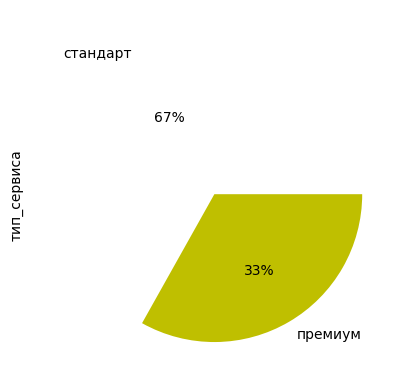

In [81]:
target_audience['тип_сервиса'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors={'w', 'y'}) ;

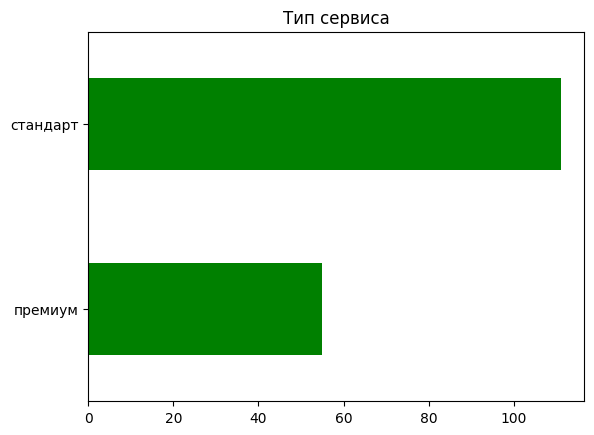

In [82]:
target_audience['тип_сервиса'].value_counts(ascending=True).plot.barh(
    title='Тип сервиса',
    color='g'
);

Почти 30% клиентов имеют премиум подписку

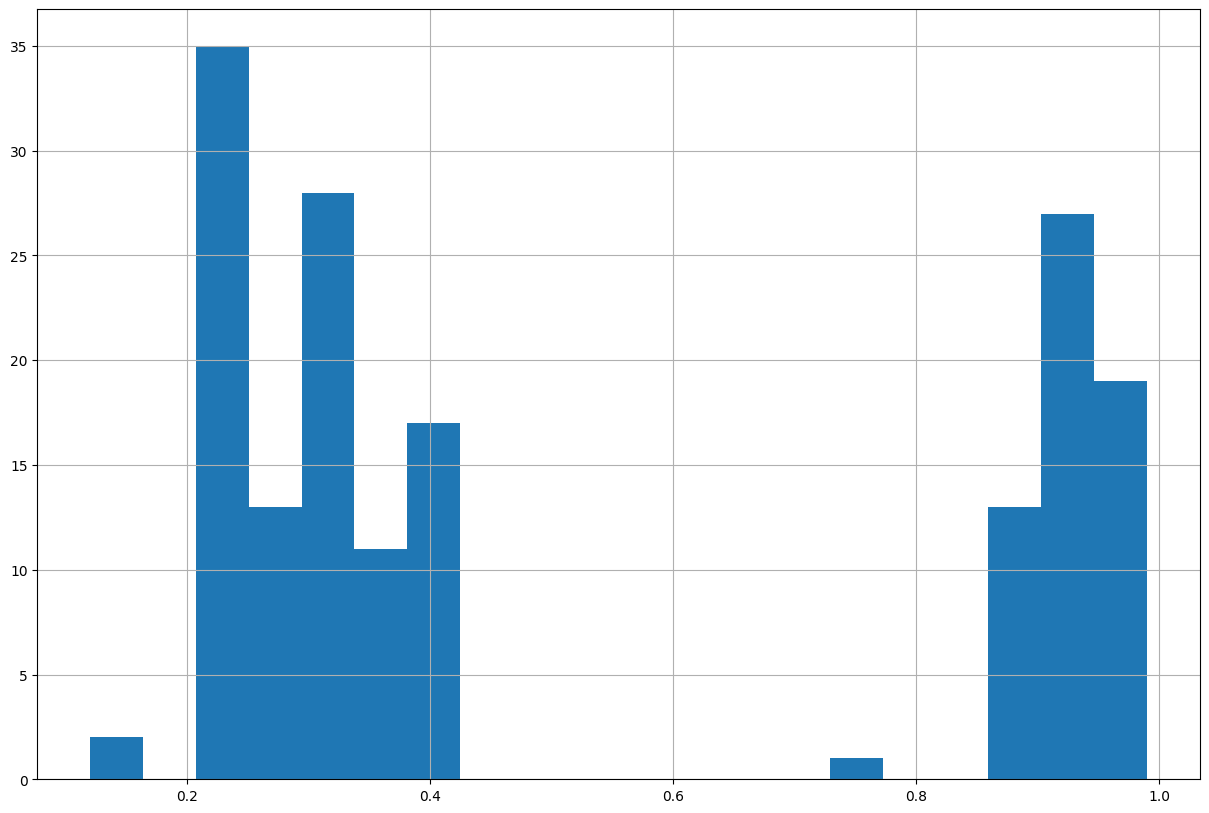

In [83]:
target_audience.акционные_покупки.hist(bins = 20, figsize = (15,10));

Большая доля клиентов готовы покупать акционные товары

Товары для детей                        24
Домашний текстиль                       14
Косметика и акссесуары                  11
Техника для красоты и здоровья           5
Кухонная посуда                          4
Мелкая бытовая техника и электроника     2
Name: популярная_категория, dtype: int64

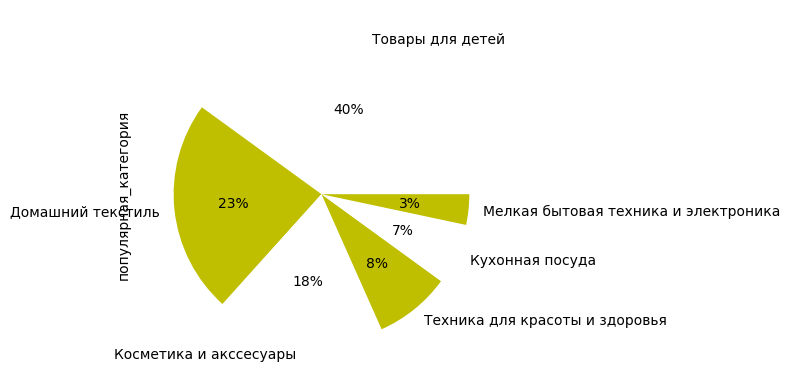

In [84]:
segmentation = target_audience.query('акционные_покупки > 0.6')
display(segmentation['популярная_категория'].value_counts())
segmentation['популярная_категория'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors={'w', 'y'}) ;

Выбрал покупателей которые имеют большую долю покупок по акции к соотношению от основных покупок(более 60%) и сгрупировал по популярным категориям

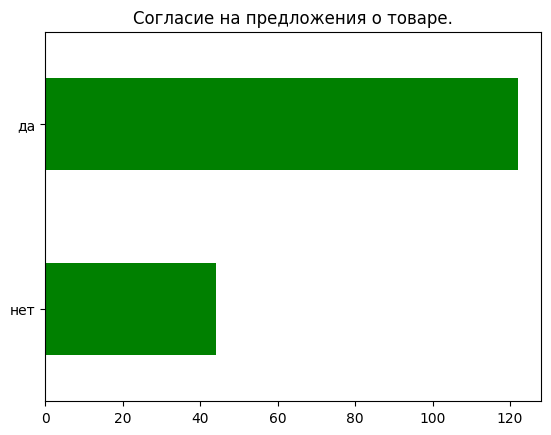

In [85]:
target_audience['разрешить_сообщать'].value_counts(ascending=True).plot.barh(
    title='Согласие на предложения о товаре.',
    color='g'
);

да     44
нет    16
Name: разрешить_сообщать, dtype: int64

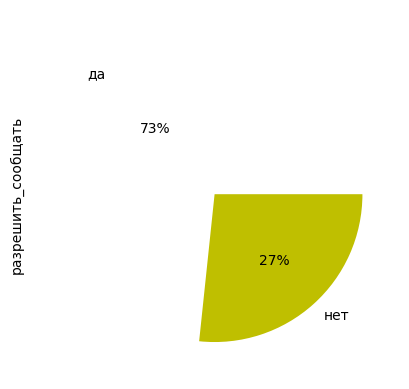

In [86]:
display(segmentation['разрешить_сообщать'].value_counts())
segmentation['разрешить_сообщать'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors={'w', 'y'}) ;

Более 70% таких покупателей хотят получать информационные рассылки.Так же покупатели совершающие акционные покупки от 60 % от числа покупок, 44(75%) из них готовы получать сообщения об акциях

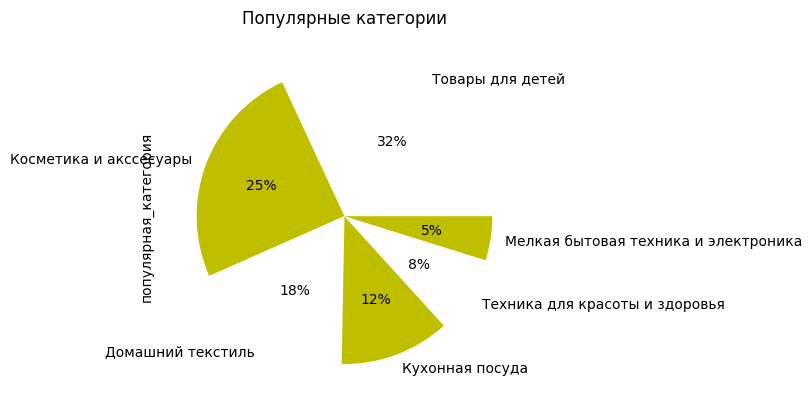

In [87]:
target_audience['популярная_категория'].value_counts().plot(
    title='Популярные категории', 
    kind='pie', autopct='%1.0f%%', colors={'w', 'y'}) ;

Доля *товаров для детей* и *косметика и аксессуары* у выбраных покупателей больше чем у всех покупателей магазина.

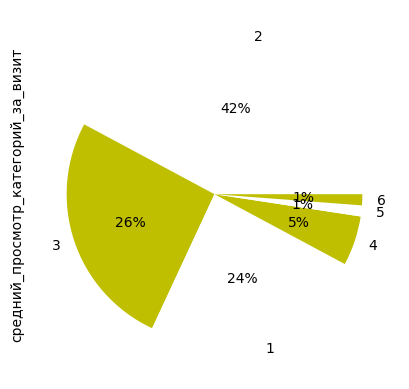

In [88]:
target_audience['средний_просмотр_категорий_за_визит'].value_counts().plot( 
    kind='pie', autopct='%1.0f%%', colors={'w', 'y'}) ;

Больше всего покупателей просмотрели 2 категории товаров,далее идет 3

Предложение увеличения покупательской активности:
- Промокоды покупателям.Большая доля клиентов готовы покупать по акции и готовы к рассылкам,можно предлагать промокоды по категориям,которыми они интересуются(до 2-х,по одному на категорию)
- Категории *премиум* дать 2 категории товаров на которую дейстует скидка,каждый месяц меняя категории для увеличения процента покупок по категориям имеющим маленький процент
- Категории *стандарт* дать скидку на переход в категорию *премиум* при покупки от 3-х товаров,тем самым переходя на пакет *премиум* они получат привелегии категории
- Увеличить время проведения на сайте(тем самым скланить к покупке) за счет промокода на определенный список товаров. 

## Общий вывод

По итогам проделанной работы было сделанно следующее:
### Открыл файл с данными и изучил иформацию
- Загрузил данные из файлов в датафреймы.
- Вывел первые строки,изучил общую информацию о датафреймах.Данные представлены в 4 таблицах.
### Предобработал данные
- Проверил на дубликаты,таковых не обнаружил.
- Названия столбцов в датафреймах перевел в нижний регистр и замени пробел на *_*
- изучил уникальные значения во всех столбцах
- заменил некоторые значения написанные с ошибкой
### Провел исследовательский анализ данных
- Вывел и изучил таблицы как категориальные, так и числовые
- вывел основные статистические характеристики данных по каждому числовому признаку
- заменил аномальное значение в столбце *выручка* на среднее по всему столбцу
- отобрал клиентов с покупательской активностью менее 3-ч месяцев,таких клиентов оказалось 3-е
### Объединил таблицы
- Объединил 3 таблицы и разбил периоды в отдельные столбцы по показателям выручки и времени
### Провел корреляционный анализ
- Посмотрел на зависимость признаков, сильная зависимость у столбцов id и покупательская_активность.Так же зависимость наблюдаем между предыдущим периодом выручки и текущим, между покупательской активностью количество страниц за визит и времени за предыдущий месяц
### Использовал пайплайн
- Заменил значения в целевом признаке на 1 и 0
- азделил df на целовой признак и признаки 75/25, использовал стратификацию
Создад пайплайн, который выберал лучшую комбинацию модели и гиперпараметров. 

* DecisionTreeClassifier()с гиперпараметрами max_depth от 2 до 4 включительно и * max_features от 2 до 4 включительно
* SVC()
* KNeighborsClassifier() с гиперпараметром n_neighbors от 2 до 4 включительно
* LogisticRegression(solver='liblinear', penalty='l1') с гиперпараметром регуляризации С от 1 до 4 включительно. 
- Так же использую два маштабирования StandardScaler()и MinMaxScaler(),OrdinalEncoder() для столбца тип_сервиса и OHE для остальных.
- Лучшей моделью получилась LogisticRegression(penalty='l1', random_state=42, solver='liblinear') с гиперпараметром регуляризации С=1.
- Далее кодировал,масштабировал и объединял данные для тестовой выборки
- Обучил модель LogisticRegression() с лучшими параметрами на тестовой выборки, результаты не сильно отличаются от тренировочной, так же Accuracy и F1-score довольно хорошие
- Проверил модель на адекватность. Метрики модели LogisticRegression() лучше чем DummyClassifier()
### Провел анализ важности признаков  методом SHAP
- Большое влияние оказывает признак страниц_за_визит,негативные значения Шепли слева от центральной вертикальной линии означают, что признак склоняет модель отнести объекты к классу 0(такой признаки как акционные_покупки), а положительные справа — к классу 1(такой признак как маркет_актив6мес), остальные 11 признаков склоняют к классу 1
- Сильнее всего на классификацию влияет признак время_текущий_месяц и перетягивает предсказание в сторону класса 0,далее идет время_предыдущий_месяц и перетягивает предсказание в сторону класса 1. Значение f(x)=-1,496 на графике показывает, что наблюдение скорее относится к классу 0
### Провел сегментация покупателей
- Добавил столбец прогноз_активности, predict_proba, он возвращает оценки вероятности для всех классов и таблицу с данными о среднемесячной прибыли магазина за последние 3 месяца
- Выбрал покупателей,которые принесли больше 4 среднемесячной прибыли(взял от пикового значения и более) и которые уйдут с вероятностью 80% и выше(в этом диапазоне наблюдается рост).Всего получилось 160 клиентов с которыми надо поработать и удержать

Предложение увеличения покупательской активности:
- Промокоды покупателям.Большая доля клиентов готовы покупать по акции и готовы к рассылкам,можно предлагать промокоды по категориям,которыми они интересуются(до 2-х,по одному на категорию)
- Категории премиум дать 2 категории товаров на которую дейстует скидка,каждый месяц меняя категории для увеличения процента покупок по категориям имеющим маленький процент
- Категории стандарт дать скидку на переход в категорию премиум при покупки от 3-х товаров,тем самым переходя на пакет премиум они получат привелегии категории
- Увеличить время проведения на сайте(тем самым скланить к покупке) за счет промокода на определенный список товаров.